In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy



# create a palette dictionary that has the same keys as the original palette
palette = cc.glasbey_hv
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [3]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/2024-04-09-DATASET-ML.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-10-DATASET.xlsx')
# df = pd.read_excel('../lc-project-data/2024-04-11-DATASET.xlsx')
# df = pd.read_excel(
#     "../Data/Original Data/2024_04_26/FINAL CORRECTED DATA 2024-04-26.xlsx"
# )

from pathlib import Path

input_path = Path("../lc-project-data")
output_path = Path("../lc-project-data")

# for MP, 
# input_path = Path("../Data/Original Data/2024_04_26")
# output_path = Path("../Data/DataV3")


df = pd.read_excel(input_path / "FINAL-CORRECTED-DATA-2024-04-26.xlsx")

In [4]:
df.shape

(5664, 692)

In [5]:
# preserve a copy for experimentation; we can allways reset to this and faster than reloading the excel file
preserved_df = df.copy()
preserved_df.shape

(5664, 692)

In [6]:
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
                }

## QA

In [7]:
df = preserved_df

In [8]:
# summarize the info about the dataframe
# note the number of columns of each type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 692 entries, record_id to biospecimen_complete
dtypes: datetime64[ns](7), float64(655), int64(10), object(20)
memory usage: 29.9+ MB


In [9]:
# A list of columns to drop
to_drop = []

In [10]:
# which columns are all nan?
nan_cols = preserved_df.columns[preserved_df.isna().all()].tolist()
print(nan_cols)
to_drop.extend(nan_cols)

['other_hhx4', 'other_hhx5', 'other_hhx6', 'other_hhx7', 'other_hhx8', 'other_hhx9', 'other_hhx10', 'medication8', 'medication9', 'medication11', 'medication12', 'medication13', 'medication14', 'medication15', 'urine', 'pao2', 'sao2', 'ph', 'paco2', 'hco3', 'aexcess', 'alactate', 'clinical_note_upload']


In [11]:
# values in gender column are very sparse
print(df["gender"].value_counts())
print(f"Nulls = {df['gender'].isna().sum()}")

# drop gender column - mostly NaN
to_drop.append("gender")


gender
FEMALE                149
MALE                   64
Male                    4
TRANSGENDER FEMALE      1
Name: count, dtype: int64
Nulls = 5446


In [12]:
# adjunctive columns - remove adj2-adj10 as they are all zeroes
adj_cols = [col for col in preserved_df.columns if 'adj' in col]

# info on the adjunctive columns
print(preserved_df[adj_cols].info())
print(preserved_df[adj_cols].describe())
print(preserved_df[adj_cols[1]].value_counts())

# all but the first adjunctive column are zeros/nans
# add them to the list to drop
to_drop.extend(adj_cols[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   adjunctive___1   3367 non-null   float64
 1   adjunctive___2   3363 non-null   float64
 2   adjunctive___3   3254 non-null   float64
 3   adjunctive___4   3254 non-null   float64
 4   adjunctive___5   3254 non-null   float64
 5   adjunctive___6   3254 non-null   float64
 6   adjunctive___7   3254 non-null   float64
 7   adjunctive___8   3254 non-null   float64
 8   adjunctive___9   3254 non-null   float64
 9   adjunctive___10  3254 non-null   float64
dtypes: float64(10)
memory usage: 442.6 KB
None
       adjunctive___1  adjunctive___2  adjunctive___3  adjunctive___4  \
count     3367.000000     3363.000000          3254.0          3254.0   
mean         0.032076        0.000297             0.0             0.0   
std          0.176228        0.017244             0.0             0.0   
m

In [13]:
print(f"Dropping {len(to_drop)} columns")

to_drop

Dropping 33 columns


['other_hhx4',
 'other_hhx5',
 'other_hhx6',
 'other_hhx7',
 'other_hhx8',
 'other_hhx9',
 'other_hhx10',
 'medication8',
 'medication9',
 'medication11',
 'medication12',
 'medication13',
 'medication14',
 'medication15',
 'urine',
 'pao2',
 'sao2',
 'ph',
 'paco2',
 'hco3',
 'aexcess',
 'alactate',
 'clinical_note_upload',
 'gender',
 'adjunctive___2',
 'adjunctive___3',
 'adjunctive___4',
 'adjunctive___5',
 'adjunctive___6',
 'adjunctive___7',
 'adjunctive___8',
 'adjunctive___9',
 'adjunctive___10']

In [14]:
try:
    df = preserved_df.drop(columns = to_drop)
except KeyError:
    # already did it and reran the cell
    pass
df.shape

(5664, 659)

In [15]:
# get all column names
df_columns = df.columns

# FEATURE SETS

## LC+, LC-, HC

- make a new column to encode status of reach record

In [16]:
# LC_positive types
pos_vals = [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals  = [3,11, 14,15]

LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC     = df.query('participant_type in @hc_vals')


df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

df['LC_STATUS'].value_counts()

LC_STATUS
LC_NEG    3367
LC_POS    2194
HC         103
Name: count, dtype: int64

In [17]:
pd.crosstab(df.dag, df.LC_STATUS).rename(index=site_name_dict)

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,32,177,110
MTL,21,1997,895
SAN,3,71,266
RIO,9,128,651
LUS,38,994,272


In [18]:
pd.crosstab(df.dag, df.LC_STATUS,normalize='index').rename(index=site_name_dict).round(2)

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,0.10,0.55,0.34
MTL,0.01,0.69,0.31
SAN,0.01,0.21,0.78
RIO,0.01,0.16,0.83
LUS,0.03,0.76,0.21


## DEMOGRAPHICS
- apr 27 - LUS increase in missing data for HCP and MICRO w apr 26 data

In [19]:
# record id
# we should leave this out - it is not useful as a feature
# it is a unique identifier for the record, but has various formats: ints, strings, uuids, etc and 
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", 
                "age", 
                # "home_location", 
                # "living_with", 
                # "number_of_persons_in_house"
                ]

# suggest leaving this out
# country of birth - not sure how useful this is
# there are about 100 different countries in the dataset, 
# with a long tail
BIRTH_COUNTRY    = [
                # "country"
                ]

# employment etc
# data is sparse, multilingual, and not useful
EMPLOYMENT   = [
                # "employed", 
                # "occupation", 
                "hcp", 
                "micro"
                ]

# the site at which the data was collected
# consider renaming this feature below
SITES        = ["dag"]

# this list drops the record id
demographic_features = df[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES]
# demographic_features = df[RECORDS + DEMOGRAPHICS + GEOGRAPHY + EMPLOYMENT + SITES]

demographic_features.shape

(5664, 5)

In [20]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sex     5614 non-null   float64
 1   age     5620 non-null   float64
 2   hcp     3290 non-null   float64
 3   micro   3163 non-null   float64
 4   dag     5664 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 221.4 KB


In [21]:
# how many nulls per site?
print("Missing DEMOGRAPHICS values by site:")
df.groupby('dag')[DEMOGRAPHICS + BIRTH_COUNTRY + EMPLOYMENT + SITES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T


Missing DEMOGRAPHICS values by site:


dag,LDN,MTL,SAN,RIO,LUS
sex,0,0,0,1,49
age,1,0,0,1,42
hcp,80,148,224,734,1188
micro,90,158,227,768,1258
dag,0,0,0,0,0


In [22]:
# drop hcp and micro columns - they are mostly NaN

# drop the columns
demographic_features.drop(columns = ["hcp", "micro"], inplace = True)
demographic_features.shape

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_56246/1475034333.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_features.drop(columns = ["hcp", "micro"], inplace = True)


(5664, 3)

In [23]:
demographic_features

,sex,age,dag
0,2.0,30.0,2
1,1.0,33.0,2
2,2.0,36.0,2
3,2.0,50.0,2
4,1.0,40.0,2
...,...,...,...
5659,1.0,48.0,3
5660,2.0,42.0,3
5661,1.0,23.0,3
5662,1.0,71.0,3


### EXPLORE: PARTICIPANT TYPES

- summary for each participant type
- not a feature set
- information only

In [24]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

LC_STATUS,HC,LC_NEG,LC_POS
participant_type,,,
1,0,7,0
2,0,0,75
3,38,0,0
4,0,0,238
5,0,328,0
6,0,0,1672
7,0,1886,0
8,0,0,83
10,0,1146,0


In [25]:
# pivot table of participant type by LC_STATUS
participant_type = df.pivot_table(index = 'participant_type', columns = 'dag', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

participant_type

dag,1,2,3,4,5
participant_type,,,,,
1,2,0,0,0,5
2,33,0,39,0,3
3,0,0,0,0,38
4,0,238,0,0,0
5,0,328,0,0,0
6,77,574,227,651,143
7,175,523,71,128,989
8,0,83,0,0,0
10,0,1146,0,0,0


### EXPLORE: Patient IDs


In [26]:
df.loc[145]

record_id                                        353
sex                                              2.0
age                                             36.0
home_location                                    1.0
living_with                                      1.0
                                       ...          
datetime_freezing                                NaN
aliquots                                         NaN
biospecimen_collection_not    10664 Volume/Notes 500
biospecimen_complete                               2
LC_STATUS                                         HC
Name: 145, Length: 660, dtype: object

In [27]:
# export the list of record_ids for the LC_POSITIVE cases
LC_pos_record_ids = df.query('participant_type in @pos_vals')['record_id']
LC_pos_record_ids

# output to a dataset

LC_pos_record_ids.to_csv(output_path / "LC_POSITIVE_RECORD_IDS.csv", index = True)


### EXPLORE: SITES

- summary of LC status by site
- not a feature set
- information only

In [28]:
# make a pivot table of the LC_STATUS by SITE
lc_site = df.pivot_table(index = 'dag', columns = 'LC_STATUS', values = 'record_id', aggfunc = 'count').fillna(0).astype(int)

# map the dag index to the site name
lc_site.index = lc_site.index.map(site_name_dict)

lc_site

LC_STATUS,HC,LC_NEG,LC_POS
dag,,,
LDN,32,177,110
MTL,21,1997,895
SAN,3,71,266
RIO,9,128,651
LUS,38,994,272


In [29]:
# how many records per site?
df['dag'].value_counts().rename(index = site_name_dict)

dag
MTL    2913
LUS    1304
RIO     788
SAN     340
LDN     319
Name: count, dtype: int64

In [30]:
# # get the range of indices for each site
# site_ranges = df.groupby('dag').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

# site_ranges.sort_values()

## SUBSTANCE USE

In [31]:
# substances
SUBSTANCES = [col for col in df.columns if "substances___" in col]

substance_features = df[SUBSTANCES]

# rename the columns with SUBST- prefix
substance_features.columns = [f"SUBST-{col.split('___')[1]}" for col in substance_features.columns]

# ==============================================================================
# 2024-04-29
# ==============================================================================
# fill the missing values with zero, per email discussion 2024-04-28?
# Q: is this valid? Asked via email Apr 29

substance_features = substance_features.fillna(0)

In [32]:
substance_features.head(), substance_features.shape

(   SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5
 0      0.0      0.0      0.0      0.0      0.0
 1      0.0      0.0      0.0      0.0      0.0
 2      0.0      0.0      0.0      0.0      0.0
 3      1.0      0.0      0.0      0.0      0.0
 4      0.0      0.0      0.0      0.0      0.0,
 (5664, 5))

In [33]:
# how many nulls per site?
print("Missing SUBSTANCES values by site:")
df.groupby('dag')[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site:


dag,LDN,MTL,SAN,RIO,LUS
substances___1,81,0,0,0,0
substances___2,81,0,0,121,1258
substances___3,81,2913,0,121,0
substances___4,81,0,0,121,1258
substances___5,81,0,0,121,0


In [34]:
# how many nulls per site?
print("Missing SUBSTANCES values by site and status:")
df.groupby(['dag','LC_STATUS'])[SUBSTANCES].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SUBSTANCES values by site and status:


dag            LDN               MTL               SAN               RIO  \
LC_STATUS       HC LC_NEG LC_POS  HC LC_NEG LC_POS  HC LC_NEG LC_POS  HC   
substances___1   0      4     77   0      0      0   0      0      0   0   
substances___2   0      4     77   0      0      0   0      0      0   0   
substances___3   0      4     77  21   1997    895   0      0      0   0   
substances___4   0      4     77   0      0      0   0      0      0   0   
substances___5   0      4     77   0      0      0   0      0      0   0   

dag                          LUS                
LC_STATUS      LC_NEG LC_POS  HC LC_NEG LC_POS  
substances___1      0      0   0      0      0  
substances___2    121      0   0    989    269  
substances___3    121      0   0      0      0  
substances___4    121      0   0    989    269  
substances___5    121      0   0      0      0

In [35]:
substance_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SUBST-1  5664 non-null   float64
 1   SUBST-2  5664 non-null   float64
 2   SUBST-3  5664 non-null   float64
 3   SUBST-4  5664 non-null   float64
 4   SUBST-5  5664 non-null   float64
dtypes: float64(5)
memory usage: 221.4 KB


## MEDICATIONS
 - one hot encode

In [37]:
# medications
# note that we already dropped the empty medication columns above
# h/t to Maitray for a nice one liner list comp
MEDTEMP = [col for col in df_columns if "medication" in col and 'medication_received' not in col]
MEDTEMP

['medication1',
 'medication2',
 'medication3',
 'medication4',
 'medication5',
 'medication6',
 'medication7',
 'medication10']

In [38]:
# read medications dict from json
import json

with open("./OUTPUT/dict-medications.json", "r") as f:
    medication_dict = json.load(f)

# cast key to int
medication_dict = {int(k): v for k, v in medication_dict.items()}

In [39]:

med_df = pd.DataFrame()

print(f">>> constructing binary columns for each unique medication")
# get all of the unique values in the medication columns
all_meds = df[MEDTEMP].values
# drop the empty strings from the_vals
all_meds = [[val for val in row if val != ""] for row in all_meds]

# fill nans with 0
all_meds = [[val if val == val else 0 for val in row] for row in all_meds]

# count the unique values in all_meds
unique_meds = np.unique(np.concatenate(all_meds))

print(f">>> \t- will add    {len(unique_meds):>4d} NEW columns")
print(f">>> \t- will remove {len(MEDTEMP):>4d} OLD columns")
print(f">>> \t- net change  {len(unique_meds) - len(MEDTEMP):>4d} columns")

# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the hx_df index as the index

encoded_meds = mlb.fit_transform(all_meds)
column_names = [f"meds_{med}" for med in mlb.classes_]
med_df = pd.DataFrame(encoded_meds, columns=column_names, index=df.index) # type: ignore

print(med_df.shape)


# drop the meds_0 column
try:
    med_df = med_df.drop(columns = "meds_0")
except KeyError:
    pass

# rename the columns using the medication_dict

for c in med_df.columns:

    # get the medication number from the column name
    mn = int(float(c.split("_")[1]))

    # look up the medication name in the medication_dict
    med_name = "MED-" + str.replace(medication_dict[mn], " ", "-")

    # rename the column
    med_df = med_df.rename(columns = {c: med_name})


>>> constructing binary columns for each unique medication
>>> 	- will add      29 NEW columns
>>> 	- will remove    8 OLD columns
>>> 	- net change    21 columns
(5664, 29)


In [40]:
# originally, I was replacing the medication columns with the new ones
# however, we won't do that here, as we want to keep the original columns

# # drop the original meds columns
# try:
#     df = df.drop(columns = MEDTEMP)
# except KeyError:
#     pass
# # df = df.drop(columns = MEDICATIONS)

# # concatenate the med_df with the original df
# df = pd.concat([df, med_df], axis = 1)


# new name for medication columns
MEDICATIONS = med_df.columns.tolist()

medication_features = med_df

In [41]:
medication_features

,MED-Analgesics,MED-Anesthetics,MED-Antibacterials,MED-Anticonvulsants,MED-Antidepressants,MED-Antifungals,MED-Antimigraine-agents,MED-Antiparasitics,MED-Antiparkinson-agents,MED-Antipsychotics,...,MED-Hormonal-agents-(adrenal),MED-Hormonal-agents-(sex-hormones),MED-Hormonal-agents-(thyroid),MED-Hormone-suppressant-(thyroid),MED-Immunological-agents,MED-Inflammatory-bowel-disease-agents,MED-Metabolic-bone-disease-agents,MED-Ophthalmic-agents,MED-Respiratory-tract-agents,MED-Skeletal-muscle-relaxants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [42]:
medication_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   MED-Analgesics                         5664 non-null   int64
 1   MED-Anesthetics                        5664 non-null   int64
 2   MED-Antibacterials                     5664 non-null   int64
 3   MED-Anticonvulsants                    5664 non-null   int64
 4   MED-Antidepressants                    5664 non-null   int64
 5   MED-Antifungals                        5664 non-null   int64
 6   MED-Antimigraine-agents                5664 non-null   int64
 7   MED-Antiparasitics                     5664 non-null   int64
 8   MED-Antiparkinson-agents               5664 non-null   int64
 9   MED-Antipsychotics                     5664 non-null   int64
 10  MED-Antispasticity-agents              5664 non-null   int64
 11  MED-Antivirals                

## HEALTH HISTORY

### HHX - Patient History

In [43]:
# find all columns with hhx in the name
HEALTH_GLOBAL = ["global"]
HHX_temp      = [col for col in df_columns if "past_hhx" in col]


In [44]:
# load a list of past hhx diags from the json file in OUTPUT

import json

with open("./OUTPUT/dict-past-hhx.json", "r") as f:
    past_hhx_dict = json.load(f)

# cast the key to an int
past_hhx_dict = {int(k): v for k, v in past_hhx_dict.items()}

In [45]:
# make a subset of the df with the past_hhx columns
hhx_df = df[HHX_temp]

# rename the columns with HHX- prefix
hhx_df.columns = [f"HHX-{past_hhx_dict[int(col.split('___')[1])]}" for col in hhx_df.columns]

hhx_df


,HHX-Arterial Hypertension,HHX-Pulmonary hypertension,HHX-Cardiovascular disease,HHX-Diabetes,HHX-Cancer,HHX-Immunosuppression,HHX-Chronic lung disease,HHX-Chronic kidney disease,HHX-Dialysis,HHX-Chronic liver disease,...,HHX-Heart failure,HHX-Coronary artery disease,HHX-Chronic hematologic disease,HHX-Malnutrition,HHX-COPD (emphysema,HHX-Psychiatric disease,HHX-Asthma,HHX-Rheumatologic disease,HHX-Past tuberculosis infection,HHX-Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5660,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5662,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [46]:
# count HX items by site
# hx_by_site = df.groupby("dag")[HEALTH_HX].sum().astype(int)
hx_by_site = df.groupby("dag")[HHX_temp].sum().astype(int)

# calculate the fraction of each hx item by site
# hx_by_site = hx_by_site.div(hx_by_site.sum(axis = 1), axis = 0)

# map index using site name dict
hx_by_site = hx_by_site.rename(index = site_name_dict)
hx_by_site.T

dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,26,655,97,43,497
past_hhx___2,1,17,4,0,0
past_hhx___3,17,193,45,0,73
past_hhx___4,22,344,86,22,183
past_hhx___5,9,232,19,2,7
past_hhx___6,7,141,7,0,8
past_hhx___7,6,105,12,0,8
past_hhx___8,5,136,15,0,6
past_hhx___9,1,15,0,0,0
past_hhx___10,1,75,9,1,1


In [47]:
# missing values by site
print("Missing HEALTH_HX values by site:")
df.groupby('dag')[HHX_temp].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing HEALTH_HX values by site:


dag,LDN,MTL,SAN,RIO,LUS
past_hhx___1,60,0,0,0,0
past_hhx___2,81,0,0,121,1258
past_hhx___3,74,0,0,121,0
past_hhx___4,66,0,0,0,0
past_hhx___5,76,0,0,0,0
past_hhx___6,80,0,0,121,0
past_hhx___7,76,0,0,121,0
past_hhx___8,81,0,0,0,0
past_hhx___9,81,0,0,0,1258
past_hhx___10,81,0,0,0,0


### HHX-OTHER - One-hot encode `other_hhx`


In [48]:
# find cols that start with other_hhx
OTHER_HHX_TEMP = [col for col in df_columns if "other_hhx" in col]
OTHER_HHX_TEMP

['other_hhx', 'other_hhx11', 'other_hhx2', 'other_hhx3']

In [49]:
# read the other-hhx dict from json
import json

with open("./OUTPUT/dict-other-hx.json", "r") as f:
    other_hx_dict = json.load(f)

# cast key to int
other_hx_dict = {int(k): v for k, v in other_hx_dict.items()}


# use a multilabel binarizer to encode the values
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# we pass the values to fit_transform, which returns a numpy array
# we then wrap the numpy array in a pandas dataframe, using the 
# encoder's classes as the column names and the df index as the index

# NOTE THAT WE ARE FILLING NANS WITH ZERO HERE
# ASSUMPTION: if it's not reported, it's not present
a = df[OTHER_HHX_TEMP].fillna(0).values
# a = df[OTHER_HHX_TEMP]

em = mlb.fit_transform(a)

column_names = [f"hhx-other-{int(c)}" for c in mlb.classes_]
other_hhx_features = pd.DataFrame(em, columns = column_names, index=df.index) # type: ignore

# drop the hhx-other-0 column
other_hhx_features.drop(columns = "hhx-other-0", inplace = True)

In [50]:

# rename the columns in qqq using the other_hx_dict
for c in other_hhx_features.columns:

    # get the  number from the column name
    num = int(float(c.split("-")[2]))

    # look up the  name in the medication_dict
    new_name = "HHX-OTHER-" + str.replace(other_hx_dict[num], " ", "-")

    # rename the column
    other_hhx_features = other_hhx_features.rename(columns = {c: new_name})

other_hhx_features

,HHX-OTHER-concussion,HHX-OTHER-hypo,HHX-OTHER-hyper,HHX-OTHER-MSK,HHX-OTHER-GI,HHX-OTHER-GERD,HHX-OTHER-DVT,HHX-OTHER-IBS,HHX-OTHER-Sleep-disorder,HHX-OTHER-Crohn's-disease,...,HHX-OTHER-UNSPECIFIED,HHX-OTHER-Celiac,HHX-OTHER-sickle-cell-anemia,HHX-OTHER-Anemia,HHX-OTHER-diverticulitis,HHX-OTHER-Derm,HHX-OTHER-ulcerative-colitis,HHX-OTHER-genetic-disorder,HHX-OTHER-fatigue,HHX-OTHER-surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# missing other hhx values by site
print("Missing OTHER_HHX values by site:")
other_hhx_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing OTHER_HHX values by site:


dag,LDN,MTL,SAN,RIO,LUS
HHX-OTHER-concussion,0,0,0,0,0
HHX-OTHER-hypo,0,0,0,0,0
HHX-OTHER-hyper,0,0,0,0,0
HHX-OTHER-MSK,0,0,0,0,0
HHX-OTHER-GI,0,0,0,0,0
HHX-OTHER-GERD,0,0,0,0,0
HHX-OTHER-DVT,0,0,0,0,0
HHX-OTHER-IBS,0,0,0,0,0
HHX-OTHER-Sleep-disorder,0,0,0,0,0
HHX-OTHER-Crohn's-disease,0,0,0,0,0


### Concatenate health history

In [52]:
# concatenate the health hx features with the other health hx features

# sort hhx_df columns
hhx_df = hhx_df.reindex(sorted(hhx_df.columns), axis=1) # type: ignore

# sort other_hhx_features columns
other_hhx_features = other_hhx_features.reindex(sorted(other_hhx_features.columns), axis=1)

# concatenate the health hx features with the other health hx features
hx_features_all = pd.concat([hhx_df, other_hhx_features], axis = 1)

In [53]:
#==============================================================================
# 2024-04-28
# In keeping with issues #1, #4, etc., - assume that if it's not reported, it wasn't volunteered by px, nor was it identified by physician/interviewer
# therefore, fill nans with zero
#==============================================================================
# 2024-04-29
# Discussed with DDF via SMS. Patient hx was taken from charts and interviews - should not be blank. Therefore fill with zero
#==============================================================================
hx_features_all = hx_features_all.fillna(0)

In [54]:
# the global health assessment is a single column
# should we add it?
# hx_features_all["HHX-global"] = df["global"]


# df["global"].value_counts()
# how many missing values?
# print(f"There are {df['global'].isna().sum()} missing values in the global health column")

# CONCLUSION: too many missing values in the global health assessment column
# we won't use it.


Text(0.5, 1.0, 'Health History Features')

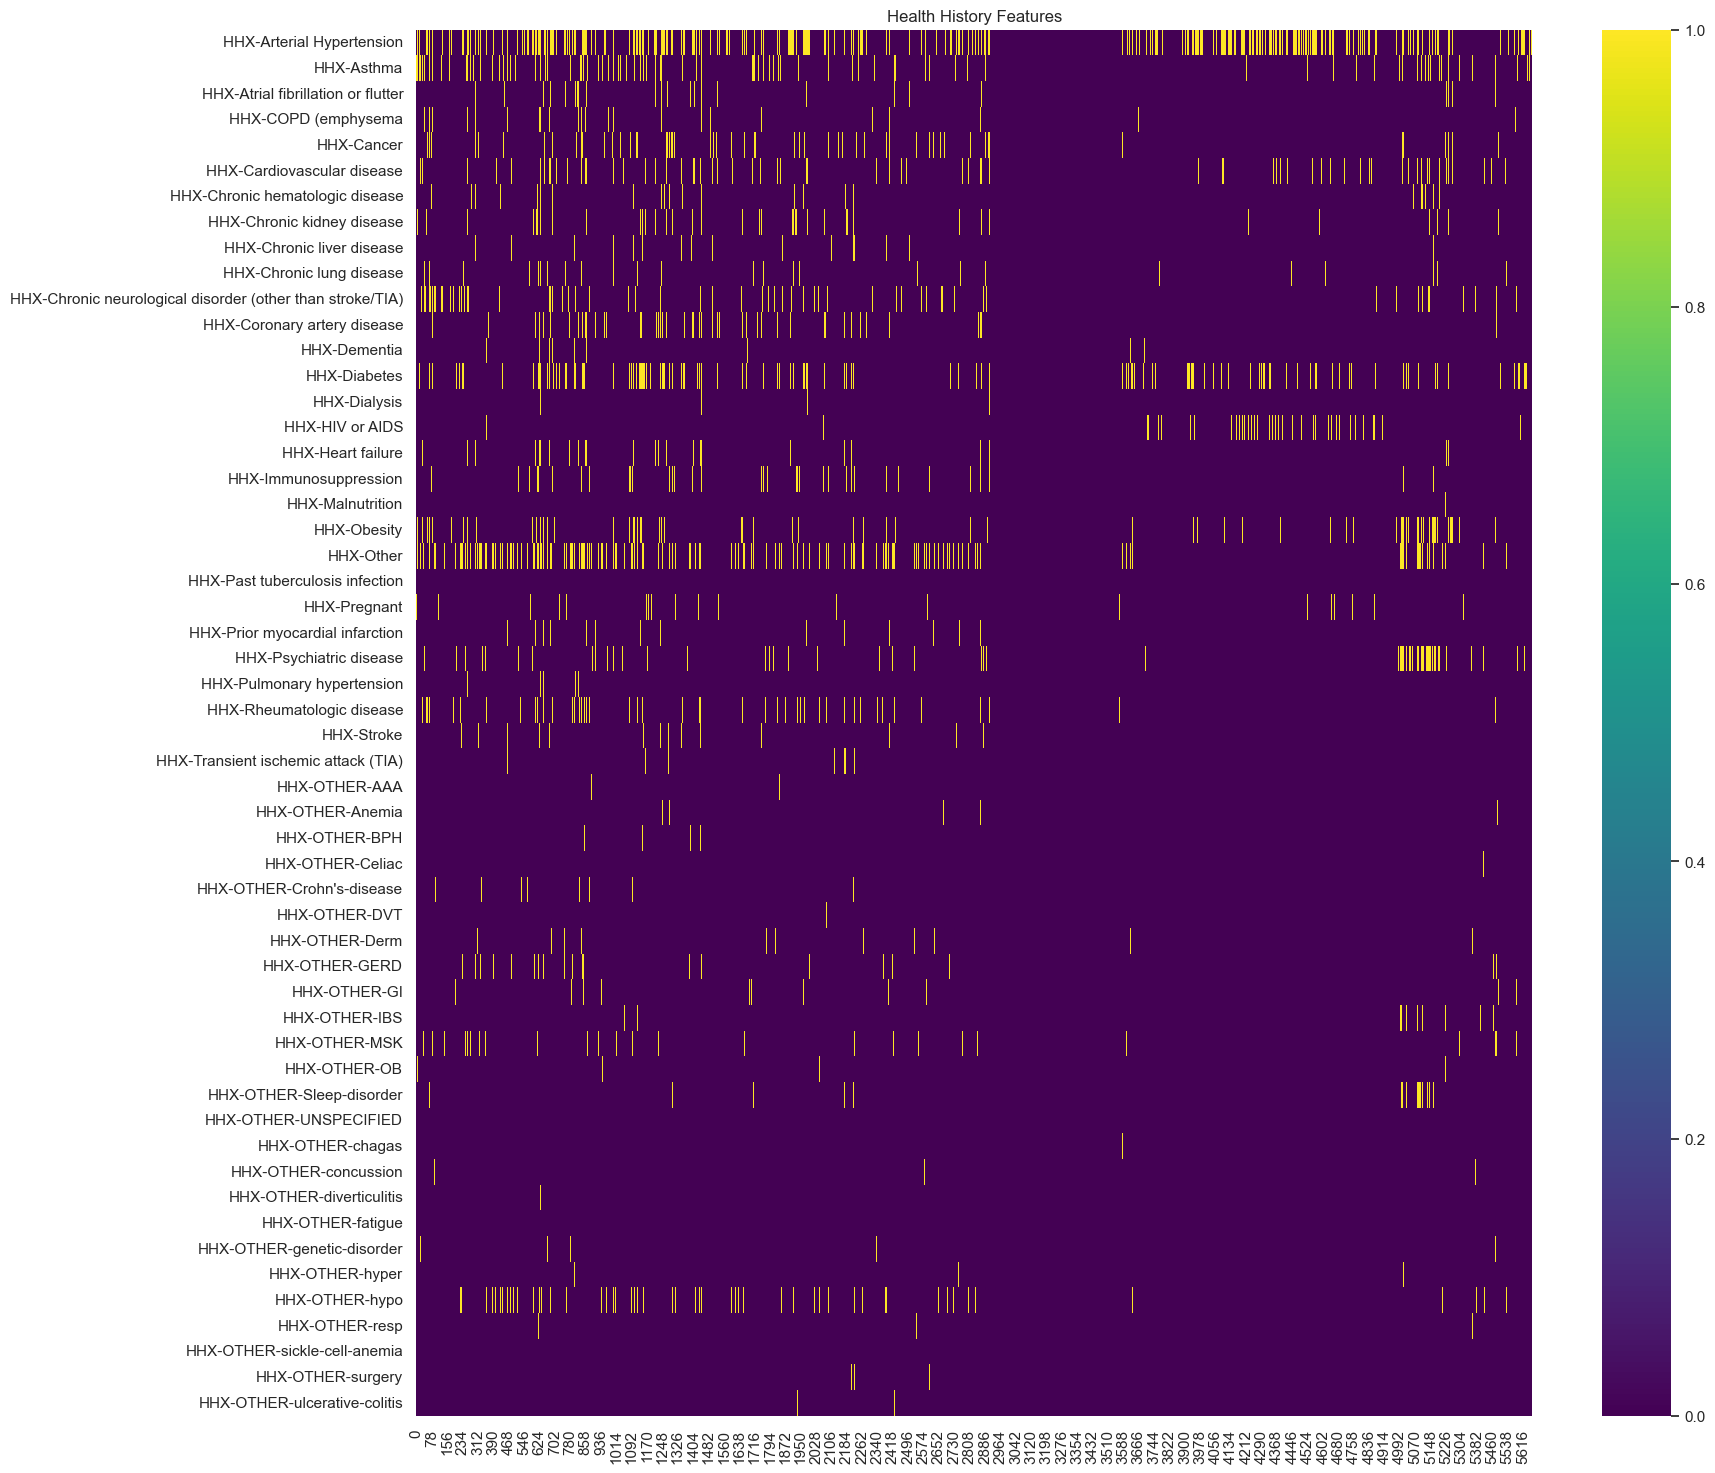

In [55]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(hx_features_all.T, cbar=True, ax = ax, cmap = 'viridis')
plt.title("Health History Features")

## SURVEYS

In [56]:
# add up the health history information

# surveys
GAD    = [col for col in df_columns if "_gad" in col if "complete" not in col]
PROMIS = [col for col in df_columns if "promis29" in col]
PHQ    = [col for col in df_columns if "phq" in col]

# remove gad_complete from GAD
# it's scooped up in the above line
# GAD = [gad for gad in GAD if "complete" not in gad]

# completeness
# these columns were intermedaries and are not useful in the analysis, so we don't need these
# PHX_COMPLETE    = ["phx_complete"]
# PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]
# PHQ_COMPLETE    = [col for col in df_columns if "patient_health_questionaire" in col]

# the set of survey columns
SURVEYS = GAD + PROMIS + PHQ

In [57]:
survey_features = df[SURVEYS]
survey_features.shape

# how many missing values?

# print("Missing SURVEY values by site:")
# df.groupby('dag')[SURVEYS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

(5664, 47)

In [58]:
# # plot it as a heatmap
# fig, ax = plt.subplots(figsize=(6,6))
# sns.heatmap(survey_features.T, cbar=True, ax = ax, cmap = 'viridis')

In [59]:
### CONCLUSION:
# - survey featureas are mostly missing, so we will not use them in the larger dataset


## SYMPTOMS

In [63]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-symptoms.json", "r") as f:
    symptoms_list = json.load(f)

# get all columns that start with the symptoms list
SYMP = [col for col in df.columns if  col.startswith(tuple(symptoms_list))]

# feature set for symptoms
symptom_features = df[SYMP]



# given that the patients were asked to mark yes/no, we assume that no response is equivalent to a "no"
# QUESTION: is this reasonable?
# ANSWER: per MP's email of 2024-04-28, we should assume that no response is equivalent to a "no" and encode as zero

# symptom_features = symptom_features.fillna(0)

# there are symptom features with a value of 2 - replace with 1
symptom_features = symptom_features.replace(2, 1)

# rename by prefixing sith SYMP
symptom_features.columns = [f"SYMPT-{col}" for col in symptom_features.columns]

# sort alphabetically
symptom_features = symptom_features.reindex(sorted(symptom_features.columns), axis=1) # type: ignore

symptom_features.shape

(5664, 56)

In [65]:
# how many nulls per site?
print("Missing SYMPTOM values by site:")
df.groupby('dag')[SYMP].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing SYMPTOM values by site:


dag,LDN,MTL,SAN,RIO,LUS
joint_pain_arthralgia___1,81,0,0,121,0
joint_pain_arthralgia___2,78,0,0,121,758
confusion_altered_mental_s___1,72,0,0,121,0
confusion_altered_mental_s___2,66,0,0,121,760
red_eye_conjunctivitis___1,81,0,0,121,1258
red_eye_conjunctivitis___2,81,0,0,121,1258
seizure___1,81,0,0,121,1258
seizure___2,81,0,0,121,1258
diarrhea___1,78,0,0,0,0
diarrhea___2,80,0,0,121,759


In [113]:
# runny_nose_rhinorrhea___1
item = "runny_nose_rhinorrhea___1"
item = "red_eye_conjunctivitis___1"

df.groupby('dag')[item].sum().rename(index = site_name_dict).T / df.groupby('dag')[item].count().rename(index = site_name_dict).T, df.groupby('dag')[item].sum().rename(index = site_name_dict).T, df.groupby('dag')[item].count().rename(index = site_name_dict).T


(dag
 LDN    0.033613
 MTL    0.013732
 SAN    0.070588
 RIO    0.000000
 LUS    0.043478
 Name: red_eye_conjunctivitis___1, dtype: float64,
 dag
 LDN     8.0
 MTL    40.0
 SAN    24.0
 RIO     0.0
 LUS     2.0
 Name: red_eye_conjunctivitis___1, dtype: float64,
 dag
 LDN     238
 MTL    2913
 SAN     340
 RIO     667
 LUS      46
 Name: red_eye_conjunctivitis___1, dtype: int64)

<Axes: xlabel='dag'>

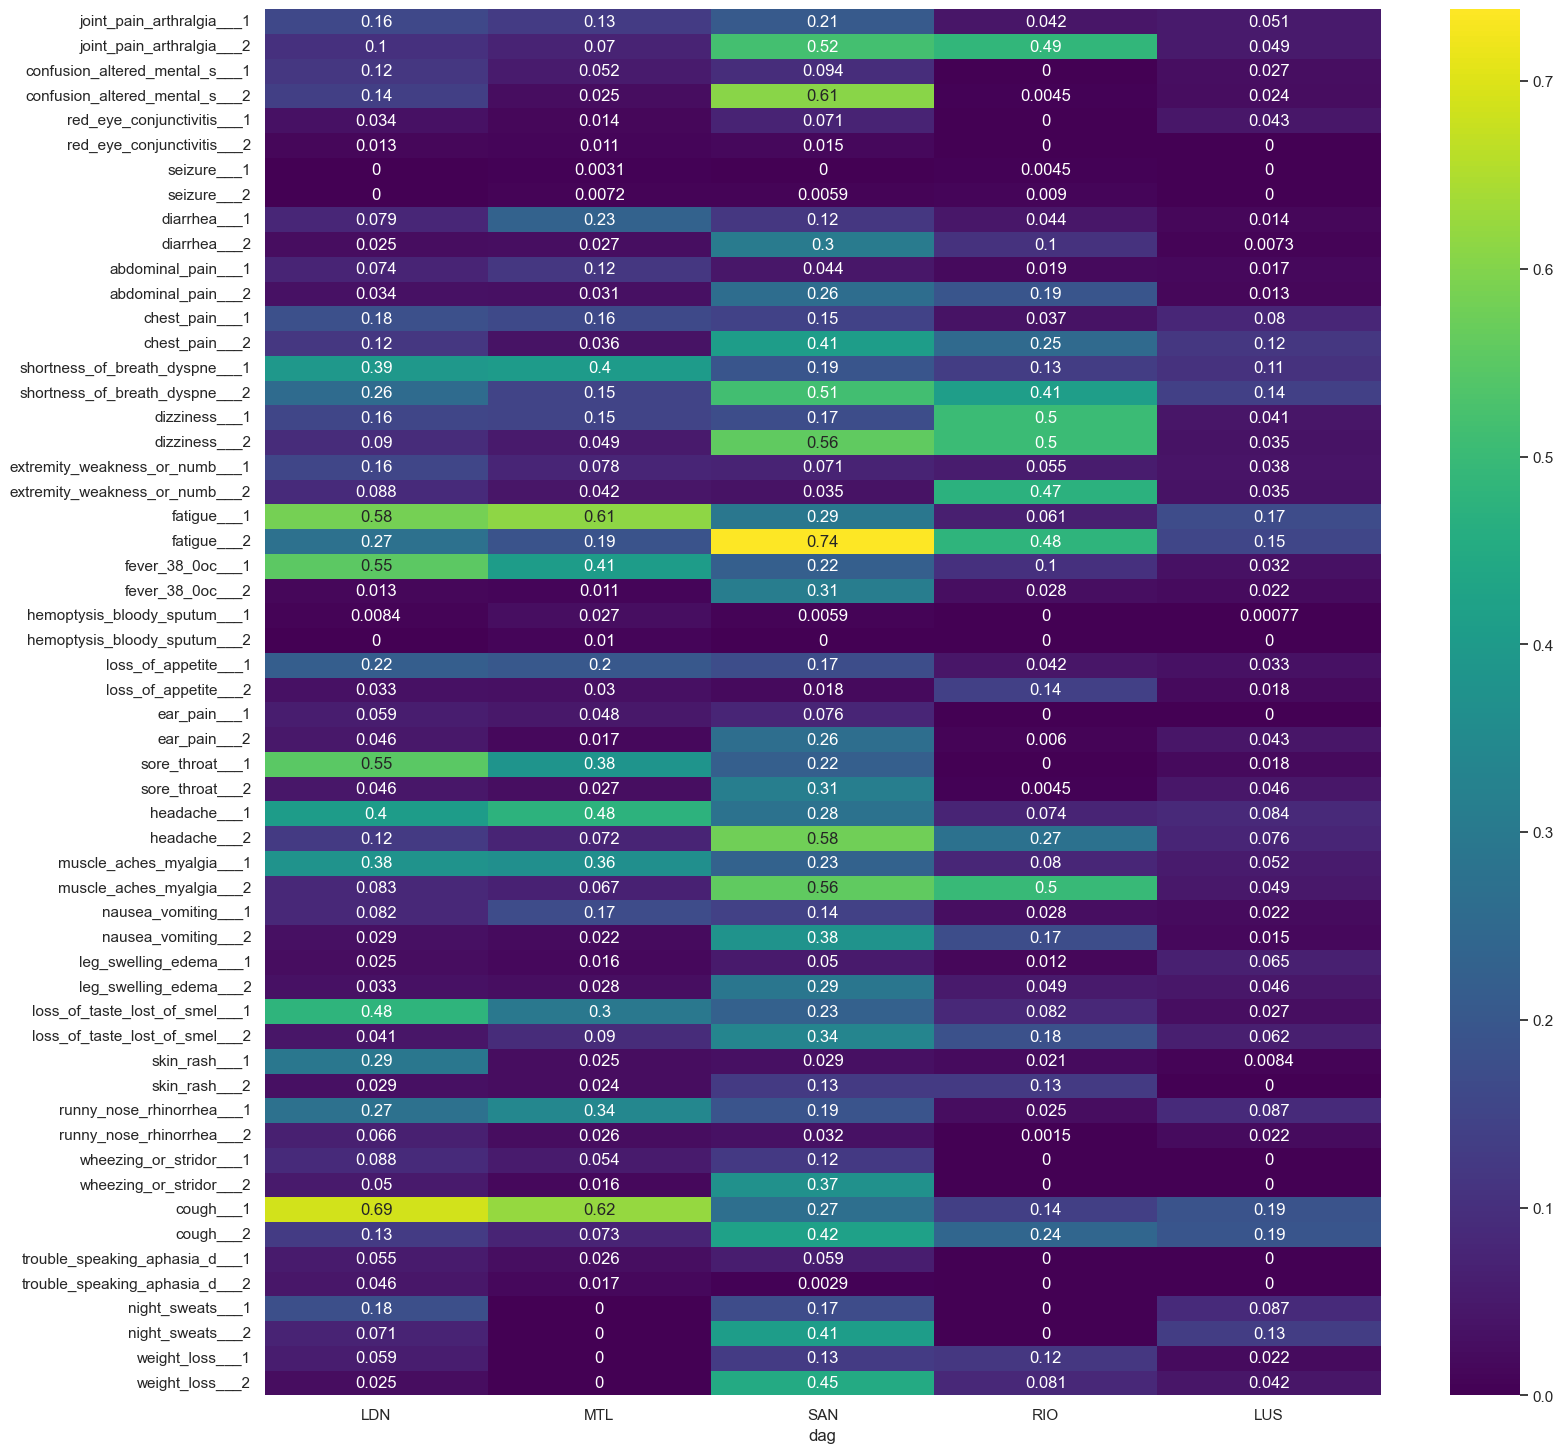

In [110]:
# get mean symptom value by site
symptom_mean = df.groupby('dag')[SYMP].sum().rename(index = site_name_dict).T / df.groupby('dag')[SYMP].count().rename(index = site_name_dict).T

fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(symptom_mean, cmap = 'viridis', annot = True, ax = ax)

In [104]:
df.groupby('dag')[SYMP].count().rename(index = site_name_dict).T

dag,LDN,MTL,SAN,RIO,LUS
joint_pain_arthralgia___1,238,2913,340,667,1304
joint_pain_arthralgia___2,241,2913,340,667,546
confusion_altered_mental_s___1,247,2913,340,667,1304
confusion_altered_mental_s___2,253,2913,340,667,544
red_eye_conjunctivitis___1,238,2913,340,667,46
red_eye_conjunctivitis___2,238,2913,340,667,46
seizure___1,238,2913,340,667,46
seizure___2,238,2913,340,667,46
diarrhea___1,241,2913,340,788,1304
diarrhea___2,239,2913,340,667,545


In [ ]:


symptom_mean[SYMP].mean(skipna = False).rename(index = site_name_dict).T
symptom_mean

sns.heatmap(symptom_mean, cmap = 'viridis')

<Axes: >

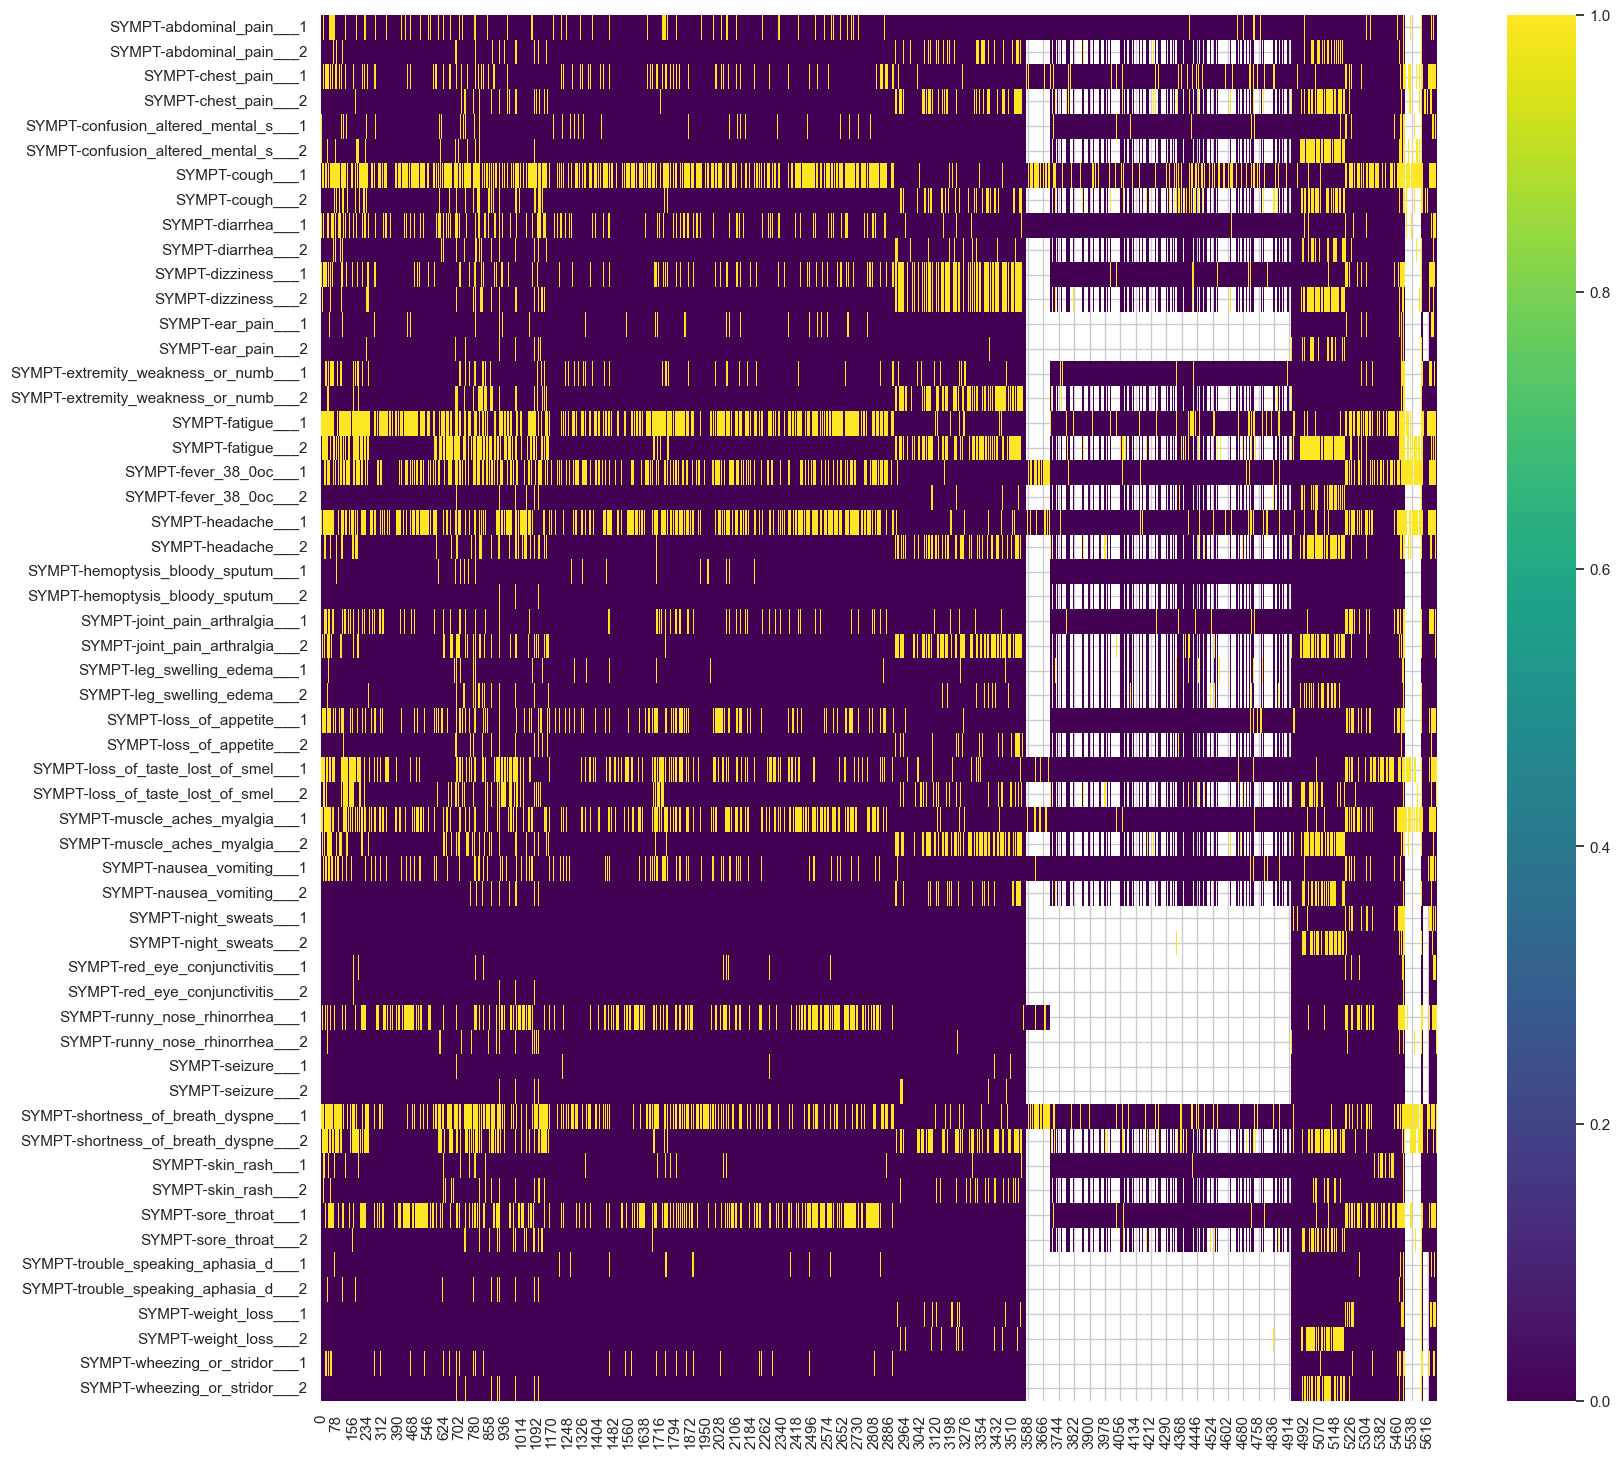

In [101]:
fig, ax = plt.subplots(figsize=(18,18))
# norm = mc.LogNorm(vmin=1, vmax=10)
sns.heatmap(symptom_features.T, cbar=True, ax = ax, norm = None,cmap = 'viridis')

## CLINICAL TESTS (AKA LABS)


- all zero: lung_function, metacholine, spirometry
- consider dropping: ct*, cx*, echo*, ekg* - similarly, mostly empty
- consider dropping features with < 200 items

In [67]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")

### IMG - Imaging

- assume that imaging (ct*, cx*, echo*, ekg*) were only ordered for patients that had symptoms or otherwised needed imaging
- for each modality, if the patient has a 1, the imaging was indicated, otherwise it was not indicated and encode a zero


In [68]:
#==============================================================================
# 2024-04-28: this is now DEPRECATED
#==============================================================================

# drop features starting with ctt and cx
# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg"))]

# # count items that start with ct
# print(df.filter(regex='^ct', axis = 1).count())
# df["ctaresult"].value_counts(), df["cttresult"].value_counts(), df["cthresult"].value_counts()
# CTA, CTT, CTH - most of the results are 2 - no report
# CONCLUSION: recommend dropping these - there are very few discriminant results
# # count items that start with cx
# print(df.filter(regex='^cx', axis = 1).count())
# # count cxr code values
# df["cxrresult"].value_counts(), df["cxrcode"].value_counts()

# # most are no-result. Of the 39 that are a positive finding, what are the results?


# # 33 fluid, etc
# # 3 fibrosis
# # 2 nodules, cysts
# # 2 congestive heart disease etc
# CONCLUSION: recommend dropping these too - very small numbers
# # # now echo
# # # count items that start with ct
# # print(df.filter(regex='^echo', axis = 1).count())

# # df["echoresult"].value_counts()
# # # mostly no reports, 7 positive findings
# # finally, ekg
# print(df.filter(regex='^ekg', axis = 1).count())

# print(df["ekgresult"].value_counts())

# print(df["ekgcode"].value_counts())

# # ekgcode results indicate 
# # 10 sinus bradycardia
# # 2 atrioventricular block
# # 1 each of supraventricular, sinus tachy, infarction

# # CONCLUSION: still recommend dropping all of the ct*, cx*, echo*, ekg* 
# # numbers are very very small
# OTHER FEATURES:
# - angiography is 7 zeroes and the rest blank
# - imaging = 12 records, imaging_results all blank
# - spirometry = 2053 records
# - spriometry_result = 27 records, of which 7 neg, 12 no report, 8 positive
# - lung_function_result = 31 records, 17 neg, 6 no report, 8 positive

In [69]:

#==============================================================================
# 2024-04-28: issue #4 - assume imaging ordered for patients who need it for 
# some reason or another
#==============================================================================
# concept: either imaging is indicated (so it is 1), or not indicated (0)
# lots of missing values -> set to 0, as we assume that imaging was not indicated

IMAGING_INVESTIGATIONS = ["cta", "cth", "ctt", "cxr", "echocardiogram", "ekg", "imaging", "angiography",'pocus']

# pretty sure spirometry isn't an imaging modality, but it was either ordered for a px, or not
print(df[IMAGING_INVESTIGATIONS].info())

# if it wasn't reported, it we assume it wasn't ordered
# fill missing values with zero
imaging_features = df[IMAGING_INVESTIGATIONS].fillna(0)

# rename the columns by prepending IMG
imaging_features.columns = [f"IMG-{col}" for col in imaging_features.columns]

# summarize
imaging_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cta             72 non-null     float64
 1   cth             73 non-null     float64
 2   ctt             292 non-null    float64
 3   cxr             327 non-null    float64
 4   echocardiogram  236 non-null    float64
 5   ekg             252 non-null    float64
 6   imaging         51 non-null     float64
 7   angiography     46 non-null     float64
 8   pocus           46 non-null     float64
dtypes: float64(9)
memory usage: 398.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMG-cta             5664 non-null   float64
 1   IMG-cth             5664 non-null   float64
 2   IMG-ctt             5664 non-null   float64
 

### LAB - Lab Tests

#### Functional tests

In [70]:
# first, functional tests:
FUNC_TESTS = ["spirometry", "lung_function","metacholine"]

func_test_features = df[FUNC_TESTS]

# assume that functional tests were ordered for a reason
# fill missing values with 0
func_test_features = func_test_features.fillna(0)

# rename the columns by prepending LAB-test-
func_test_features.columns = [f"LAB-test-{col}" for col in func_test_features.columns]

func_test_features.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LAB-test-spirometry     5664 non-null   float64
 1   LAB-test-lung_function  5664 non-null   float64
 2   LAB-test-metacholine    5664 non-null   float64
dtypes: float64(3)
memory usage: 132.9 KB


#### Lab tests

In [71]:
# now, lab tests that aren't imaging or functional
# drop the columns
CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "spirometry", "metacholine", "lung_function"))]


# CLINICAL_TESTS = [col for col in CLINICAL_TESTS if not col.startswith(("ctt", "cth", "cta", "cx", "echo", "ekg", "angiography", "imaging", "cd4", "cd8", "stented", "troponin", "pocus", "igg", "ntprobnp", "bnp", "spirometry", "metacholine", "lung_function", "il6", "angiography"))]

df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   albumin           1375 non-null   float64
 1   alt               1723 non-null   float64
 2   aptt              580 non-null    float64
 3   ast               1062 non-null   float64
 4   basophil          594 non-null    float64
 5   basophil_count    835 non-null    float64
 6   bilirubin         1453 non-null   float64
 7   bilirubin_direct  696 non-null    float64
 8   bnp               18 non-null     float64
 9   cd4               2 non-null      float64
 10  cd8               2 non-null      float64
 11  cpk               151 non-null    float64
 12  creatinine        1483 non-null   float64
 13  crp               1590 non-null   float64
 14  eosinophil        548 non-null    float64
 15  eosinophil_count  836 non-null    float64
 16  ferritin          898 non-null    float64


In [72]:
# fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm, cmap = 'viridis')
# plt.title("LAB Tests")

##### Treat Outliers

In [73]:
# treat outliers before imputing data
# if we even impute the data

from project_modules.data_prep import treat_outliers
labs_without_outliers = treat_outliers(df[CLINICAL_TESTS], z_threshold = 4, method = "median")

>>> Using z-threshold = 4.00 to identify outliers.
>>> There are 213 outliers in the data for abs(z) ≥ 4.00.
>>> Outliers are 3.76% of the total data.
>>> Replacing outliers with median.
albumin              40.000
alt                  27.000
aptt                 31.550
ast                  23.000
basophil              0.000
basophil_count        0.000
bilirubin             5.000
bilirubin_direct      0.100
bnp                  30.000
cd4                   0.470
cd8                   0.365
cpk                 107.000
creatinine           78.000
crp                   6.950
eosinophil            0.100
eosinophil_count      1.000
ferritin            156.000
fibrinogen            3.400
glucose               6.100
haemoglobin         134.000
igg                   9.000
il6                  35.100
inr                   1.100
ldh                 298.000
lymphocyte            1.200
lymphocyte_count     24.000
monocyte              0.600
monocyte_count        6.000
neutrophil            6.500
n

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [74]:
labs_without_outliers.describe()

,albumin,alt,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,bnp,cd4,...,potassium,sodium,stented,triglycerides,troponini,troponinihigh,troponint,troponinthigh,urea,wbc
count,1375.000000,1723.000000,580.000000,1062.00000,594.000000,835.000000,1453.000000,696.000000,18.000000,2.000000,...,1051.000000,1052.000000,46.0,857.000000,112.000000,207.000000,27.000000,266.000000,1272.000000,2047.000000
mean,39.169745,34.926837,31.978948,29.66629,0.139899,0.100240,11.367626,0.914943,98.388889,0.470000,...,4.084110,137.673954,0.0,103.366978,21.016161,55.768116,34.037037,24.526316,4.289087,7.398935
std,4.651187,24.983795,7.653760,21.84581,0.203860,0.295611,17.971952,3.297386,124.001963,0.169706,...,0.535132,4.071105,0.0,99.027451,23.110617,304.134304,41.683313,31.022592,3.838247,3.055987
min,17.000000,5.000000,1.400000,1.60000,0.000000,0.000000,0.000000,0.000000,7.000000,0.350000,...,2.200000,121.000000,0.0,0.100000,0.010000,2.000000,5.000000,1.000000,0.300000,1.000000
25%,37.000000,19.000000,27.275000,17.00000,0.000000,0.000000,0.500000,0.100000,21.000000,0.410000,...,3.800000,136.000000,0.0,1.700000,5.000000,4.450000,11.000000,8.000000,1.610000,5.400000
50%,40.000000,27.000000,31.525000,23.00000,0.000000,0.000000,5.000000,0.100000,30.000000,0.470000,...,4.100000,138.000000,0.0,92.000000,14.000000,8.000000,19.000000,14.000000,3.300000,6.900000
75%,42.000000,41.000000,35.200000,33.00000,0.200000,0.000000,12.000000,0.100000,112.500000,0.530000,...,4.400000,140.000000,0.0,149.000000,26.000000,17.800000,33.000000,26.000000,5.625000,8.800000
max,51.000000,179.400000,79.900000,161.00000,0.900000,1.000000,114.920000,23.200000,432.000000,0.590000,...,6.500000,153.000000,0.0,568.000000,111.000000,4028.500000,193.000000,222.000000,22.800000,22.500000


##### Consider Imputation by Site 
Summary -- Too many missing per site -- avoid imputation - MP Apr 28

In [75]:
print('Percent Missing of Lab By Site')
(df.groupby("dag")[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(
    index=site_name_dict
).T / df.dag.value_counts().rename(index=site_name_dict)).round(2)

Percent Missing of Lab By Site


dag,LDN,LUS,MTL,RIO,SAN
albumin,0.99,1.00,0.82,0.20,0.34
alt,0.77,0.94,0.79,0.06,0.35
aptt,1.00,1.00,0.84,0.87,1.00
ast,1.00,0.94,0.94,0.06,0.82
basophil,1.00,1.00,0.87,1.00,0.40
basophil_count,0.94,1.00,1.00,0.19,0.48
bilirubin,0.98,1.00,0.80,0.20,0.34
bilirubin_direct,1.00,1.00,0.98,0.20,0.95
bnp,1.00,1.00,1.00,1.00,0.97
cd4,1.00,1.00,1.00,1.00,1.00


Percent Missing of Lab By Site


Text(0.5, 1.0, 'Percent of Lab Missing By Site')

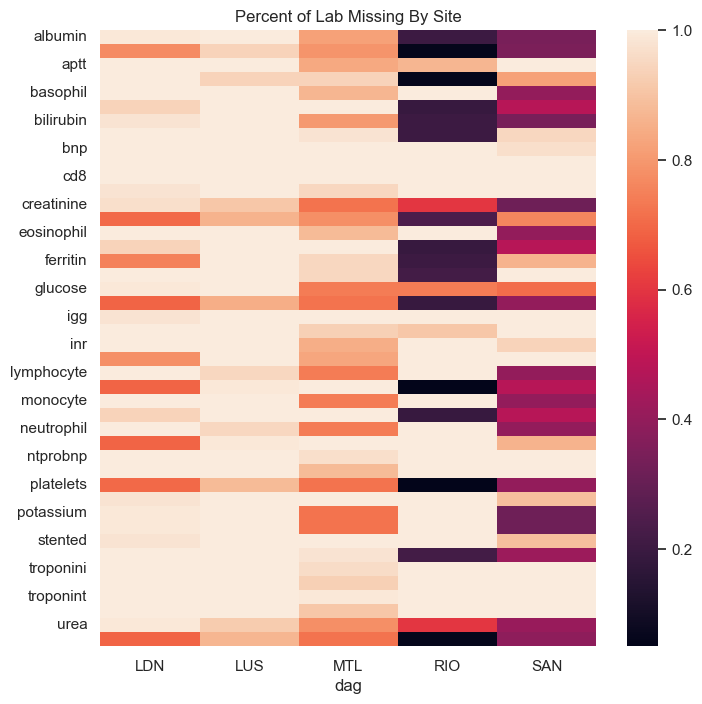

In [76]:
print('Percent Missing of Lab By Site')
sns.heatmap(
    (
        df.groupby("dag")[CLINICAL_TESTS]
        .apply(lambda x: x.isnull().sum())
        .rename(index=site_name_dict)
        .T
        / df.dag.value_counts().rename(index=site_name_dict)
    ).round(2)
)
plt.title("Percent of Lab Missing By Site")

In [77]:
#shows that there are no real good labs that have a decent number across all sites.. we just wouldnt beable to control for site differences between labs if imputed
print('Maximum percent missing per lab across all site.')
((df.groupby("dag")[CLINICAL_TESTS].apply(
    lambda x: x.isnull().sum()
).T / df.dag.value_counts()).round(2)).T.max().sort_values()

Maximum percent missing per lab across all site.


haemoglobin         0.85
crp                 0.86
wbc                 0.87
platelets           0.88
alt                 0.94
creatinine          0.97
urea                0.99
troponinihigh       1.00
monocyte            1.00
monocyte_count      1.00
neutrophil          1.00
neutrophil_count    1.00
ntprobnp            1.00
pct                 1.00
troponinthigh       1.00
lymphocyte_count    1.00
pocus               1.00
potassium           1.00
sodium              1.00
stented             1.00
triglycerides       1.00
troponini           1.00
troponint           1.00
lymphocyte          1.00
albumin             1.00
inr                 1.00
aptt                1.00
ast                 1.00
basophil            1.00
basophil_count      1.00
bilirubin           1.00
bilirubin_direct    1.00
bnp                 1.00
ldh                 1.00
cd4                 1.00
cpk                 1.00
eosinophil          1.00
eosinophil_count    1.00
ferritin            1.00
fibrinogen          1.00


In [78]:
# how many nulls per site?
print("Missing LAB values by site:")
df.groupby('dag')[CLINICAL_TESTS].apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.map(lambda x: f"{x:,}") # type: ignore


Missing LAB values by site:


dag,LDN,MTL,SAN,RIO,LUS
albumin,315,"2,395",117,158,"1,304"
alt,246,"2,303",118,48,"1,226"
aptt,318,"2,436",340,686,"1,304"
ast,319,"2,728",279,48,"1,228"
basophil,319,"2,523",136,788,"1,304"
basophil_count,300,"2,913",162,150,"1,304"
bilirubin,313,"2,323",116,155,"1,304"
bilirubin_direct,319,"2,867",324,154,"1,304"
bnp,319,"2,906",329,788,"1,304"
cd4,319,"2,911",340,788,"1,304"


##### consider imputing the labs data, by sex and by site

Text(0.5, 1.0, 'Median Values of LAB Tests by Site')

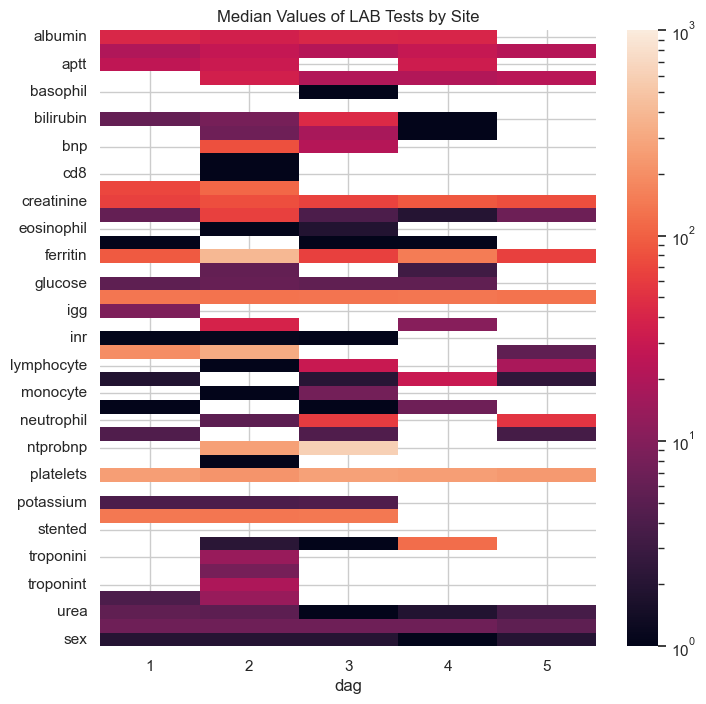

In [79]:
# given the labs_without_outliers, we need to add sex and site back in
# we also need to add in the LC_STATUS column

t1 = pd.concat([labs_without_outliers, df[["sex", "dag"]]
                ], axis = 1)

norm = mc.LogNorm(vmin=1, vmax=1_000)

# get means by site
sns.heatmap(t1.groupby("dag").median().T, norm = norm)
plt.title("Median Values of LAB Tests by Site")


In [80]:
# 2024-04-28: this is now DEPRECATED
# originally the haemoglobin values were measured in different unit systems

# # let's have a look
# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = t1, x = "dag", y = "haemoglobin", ax = ax)

# # simple unit check
# # hameoglobin is specified in diction as [g L^-1]
# # normal range is 130-180 [g L^-1]
# # LUSAKA values are in the 10s, so must be in [g dL^-1]
# # convert to [g L^-1]

# # find the LUSAKA values
# lusaka_haemoglobin = t1.query('dag == 5')["haemoglobin"]

# # convert to [g L^-1]
# lusaka_haemoglobin = lusaka_haemoglobin * 10

# lusaka_haemoglobin.describe()

# # now we can see that the values are in the normal range

# # replace the values in the dataframe
# t1.loc[t1["dag"] == 5, "haemoglobin"] = lusaka_haemoglobin

# # haemoglobin values look odd in a table DT made
# # let's have a look

# # plot haemoglobin by site
# fig, ax = plt.subplots(figsize=(6,6))

# sns.boxplot(data = t1, x = t1["dag"].map(site_name_dict), y = "haemoglobin", ax = ax)

In [81]:
median_by_site_and_sex = t1.groupby(["sex", "dag"]).median().T
median_by_site_and_sex

sex                  1.0                                       2.0          \
dag                    1       2        3        4       5       1       2   
albumin            44.00   36.00   42.000   42.000     NaN   40.00   37.00   
alt                24.00   32.00   30.500   34.000   26.00   16.00   23.00   
aptt               26.00   31.55      NaN   33.000     NaN     NaN   30.70   
ast                  NaN   39.00   27.000   23.000   23.40     NaN   33.50   
basophil             NaN    0.00    0.400      NaN     NaN     NaN    0.00   
basophil_count      0.10     NaN    0.000    0.000     NaN    0.00     NaN   
bilirubin           5.50    9.00   44.200    0.500     NaN    6.00    7.00   
bilirubin_direct     NaN    8.80   17.700    0.100     NaN     NaN    3.75   
bnp                  NaN   80.00  111.000      NaN     NaN     NaN     NaN   
cd4                  NaN    0.35      NaN      NaN     NaN     NaN    0.59   
cd8                  NaN    0.30      NaN      NaN     NaN     NaN    0.43   
cpk                  NaN  153.00      NaN      NaN     NaN   71.00   65.00   
creatinine        105.00   85.00   82.200   95.472   85.60   63.00   64.00   
crp                 4.30   77.60    3.500    2.000    6.80    6.00   46.20   
eosinophil           NaN    0.10    2.050      NaN     NaN     NaN    0.10   
eosinophil_count    0.20     NaN    0.200    2.000     NaN    0.20     NaN   
ferritin          198.00  555.00  115.200  213.000     NaN   65.65  266.40   
fibrinogen           NaN    6.10      NaN    3.000     NaN     NaN    5.30   
glucose              NaN    6.45    6.700    5.600     NaN    5.40    6.00   
haemoglobin       145.50  138.00  149.000  147.000  137.00  134.00  125.00   
igg                 9.60     NaN      NaN      NaN     NaN    7.00     NaN   
il6                  NaN   45.30      NaN   11.600     NaN     NaN   28.05   
inr                 0.90    1.20    1.000      NaN     NaN     NaN    1.10   
ldh               199.00  331.00      NaN      NaN     NaN  189.00  293.50   
lymphocyte           NaN    0.80   27.950      NaN   18.15     NaN    1.00   
lymphocyte_count    1.95     NaN    2.100   29.000    1.07    1.90     NaN   
monocyte             NaN    0.50    8.400      NaN     NaN     NaN    0.50   
monocyte_count      0.60     NaN    0.600    7.000     NaN    0.50     NaN   
neutrophil           NaN    5.70   59.850      NaN   41.15     NaN    4.80   
neutrophil_count    4.30     NaN    4.505      NaN    3.91    3.95     NaN   
ntprobnp             NaN  262.00  614.000      NaN     NaN     NaN  258.50   
pct                  NaN    0.15      NaN      NaN     NaN     NaN    0.10   
platelets         219.00  210.00  233.000  246.000  206.00  266.00  228.00   
pocus               0.00     NaN    0.000      NaN     NaN    0.00     NaN   
potassium            NaN    4.00    4.200      NaN     NaN    4.00    3.90   
sodium               NaN  137.00  140.000      NaN     NaN  141.00  138.00   
stented             0.00     NaN    0.000      NaN     NaN    0.00     NaN   
triglycerides        NaN    1.70    0.400  126.000     NaN     NaN    2.55   
troponini            NaN   16.50      NaN      NaN     NaN     NaN    9.50   
troponinihigh        NaN    8.65      NaN      NaN     NaN     NaN    6.80   
troponint            NaN   17.00      NaN      NaN     NaN     NaN   33.00   
troponinthigh        NaN   16.50      NaN      NaN     NaN    4.00   11.00   
urea                8.70    5.80    0.800    1.998    4.00    5.20    4.30   
wbc                 7.20    7.20    6.900    6.990    5.42    7.05    6.60   

sex                                          
dag                     3         4       5  
albumin            42.000   40.0000     NaN  
alt                20.500   25.3000   20.00  
aptt                  NaN   30.0000     NaN  
ast                20.000   19.0000   21.60  
basophil            0.300       NaN     NaN  
basophil_count      0.000    0.0000     NaN  
bilirubin          35.400    0.4000     NaN

In [82]:
                                 
# # group by sex and dag
# t2 = t1.groupby(["sex", "dag"]).transform(lambda x: x.fillna(x.median()))

# # heatmap
# fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [83]:
# # are there records that are entirely nan?
# t2[t2.isna().all(axis = 1)]
# t2.dropna(how = 'all', inplace = True)
# # heatmap
# fig, ax = plt.subplots(figsize=(16,16))
# norm = mc.LogNorm(vmin=1, vmax=10_000)
# sns.heatmap(t2.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [84]:
# # drop some additional labs that have poor coverage

# CT2 = [col for col in CLINICAL_TESTS if not col.startswith(("eos", "meta", "m,ono", "neutro","potas","sodiu", "tri", "baso", "mono", "lymph"))]

# t3 = t2[CT2]

# # heatmap
# fig, ax = plt.subplots(figsize=(16,16))

# norm = mc.LogNorm(vmin=1, vmax=10_000)

# sns.heatmap(t3.T, cbar=True, ax = ax, cmap = 'viridis', norm = norm)

In [85]:
# # which features have a complete set of data (no missing values)?

# complete_features = t3.dropna(axis = 1, how = 'any') # type: ignore
# complete_features

##### Check distribution of complete_features by sex and dag

In [86]:
# pd.crosstab(t1.dag,t1.sex)

In [87]:
# t1.groupby(["dag", "sex"]).count()[
#     [
#         "LABS-alt",
#         "LABS-creatinine",
#         "LABS-crp",
#         "LABS-haemoglobin",
#         "LABS-platelets",
#         "LABS-urea",
#         "LABS-wbc",
#     ]
# ]

##### Generate lab_features

In [88]:
# lab_features 

In [89]:
# WIP: DO NOT IMPUTE

# no imputation
lab_features = labs_without_outliers
lab_features_ind = deepcopy(lab_features)

# no imputation, fixed LUS haemo values ## 2024-04-28: this is now DEPRECATED
# lab_features = t1.drop(["sex", "dag"], axis = 1)


# EXPT: use the reduced set of labs
# lab_features = complete_features

# rename the colummns by prefixing with LABS
lab_features.columns = [f"LABS-{col}" for col in lab_features.columns]

lab_features.shape

(5664, 44)

In [90]:
# ==============================================================================
# 2024-04-28: issue #3 - assume lab ordered for patients who need it for
# some reason or another
# ==============================================================================
# concept: either lab is indicated (so it is 1), or not indicated (0)
# lots of missing values -> set to 0, as we assume that lab was not indicated

# lab_features_ind = deepcopy(lab_features)
lab_features_ind = lab_features_ind.fillna(0)
lab_features_ind[lab_features_ind>0] = 1
lab_features_ind.columns = [f"LABS-IND-{col}" for col in lab_features_ind.columns]

In [91]:
lab_features.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LABS-albumin           1375 non-null   float64
 1   LABS-alt               1723 non-null   float64
 2   LABS-aptt              580 non-null    float64
 3   LABS-ast               1062 non-null   float64
 4   LABS-basophil          594 non-null    float64
 5   LABS-basophil_count    835 non-null    float64
 6   LABS-bilirubin         1453 non-null   float64
 7   LABS-bilirubin_direct  696 non-null    float64
 8   LABS-bnp               18 non-null     float64
 9   LABS-cd4               2 non-null      float64
 10  LABS-cd8               2 non-null      float64
 11  LABS-cpk               151 non-null    float64
 12  LABS-creatinine        1483 non-null   float64
 13  LABS-crp               1590 non-null   float64
 14  LABS-eosinophil        548 non-null    float64
 15  LABS

In [92]:
lab_features_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LABS-IND-albumin           5664 non-null   float64
 1   LABS-IND-alt               5664 non-null   float64
 2   LABS-IND-aptt              5664 non-null   float64
 3   LABS-IND-ast               5664 non-null   float64
 4   LABS-IND-basophil          5664 non-null   float64
 5   LABS-IND-basophil_count    5664 non-null   float64
 6   LABS-IND-bilirubin         5664 non-null   float64
 7   LABS-IND-bilirubin_direct  5664 non-null   float64
 8   LABS-IND-bnp               5664 non-null   float64
 9   LABS-IND-cd4               5664 non-null   float64
 10  LABS-IND-cd8               5664 non-null   float64
 11  LABS-IND-cpk               5664 non-null   float64
 12  LABS-IND-creatinine        5664 non-null   float64
 13  LABS-IND-crp               5664 non-null   float

## CLINICAL DETAILS

In [88]:
# 2024-04-28
# reconsidering this in light of some email discussions.
# - let's leave it as CD-* for all of the clinical details columns
# - we should rename any of the ones that start are generic
# "complications" ones with COMP

In [89]:
# read the list of symtpoms from the json file
import json
with open("./OUTPUT/list-clin-details.json", "r") as f:
    cd_list = json.load(f)

# get all columns that start with the symptoms list
CD = [col for col in df.columns if  col.startswith(tuple(cd_list))]

# delete items that sstart with phx and phq
# the are scooped up by accident because cd_list contains "ph"
CD = [col for col in CD if not col.startswith(("phx", "phq"))]

# feature set for symptoms
cd_features = df[CD]

# preprend CLIN- to the column names
cd_features.columns = [f"CD-{col}" for col in cd_features.columns]

# find spaces in the data and replace with zero
cd_features = cd_features.replace(" ", 0)

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_80466/2295893641.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd_features = cd_features.replace(" ", 0)


In [90]:
# find items in CD that include "complic"
# these are the complications columns
complications = [col for col in cd_features.columns if "complic" in col if "of_the_endoc" not in col]
complications

['CD-cardiovascular_complicatio___1',
 'CD-cardiovascular_complicatio___2',
 'CD-cardiovascular_complicatio___3',
 'CD-cardiovascular_complicatio___4',
 'CD-respiratory_complications___1',
 'CD-respiratory_complications___2',
 'CD-respiratory_complications___3',
 'CD-respiratory_complications___4',
 'CD-renal_complications___1',
 'CD-renal_complications___2',
 'CD-renal_complications___3',
 'CD-renal_complications___4',
 'CD-neurologic_complications___1',
 'CD-neurologic_complications___2',
 'CD-neurologic_complications___3',
 'CD-neurologic_complications___4',
 'CD-psychiatric_complications___1',
 'CD-psychiatric_complications___2',
 'CD-psychiatric_complications___3',
 'CD-psychiatric_complications___4',
 'CD-gastrointestinal_complicat___1',
 'CD-gastrointestinal_complicat___2',
 'CD-gastrointestinal_complicat___3',
 'CD-gastrointestinal_complicat___4']

In [91]:
# for each item in complications, split at the first underscore and rename the column
for col in complications:
    new_name =  col.split("_", 1)[0] + "-other-" + col.split("___", 1)[1]
    print(new_name)
    cd_features = cd_features.rename(columns = {col: new_name})

CD-cardiovascular-other-1
CD-cardiovascular-other-2
CD-cardiovascular-other-3
CD-cardiovascular-other-4
CD-respiratory-other-1
CD-respiratory-other-2
CD-respiratory-other-3
CD-respiratory-other-4
CD-renal-other-1
CD-renal-other-2
CD-renal-other-3
CD-renal-other-4
CD-neurologic-other-1
CD-neurologic-other-2
CD-neurologic-other-3
CD-neurologic-other-4
CD-psychiatric-other-1
CD-psychiatric-other-2
CD-psychiatric-other-3
CD-psychiatric-other-4
CD-gastrointestinal-other-1
CD-gastrointestinal-other-2
CD-gastrointestinal-other-3
CD-gastrointestinal-other-4


In [92]:
# bring back the endocrine complications
# endocrine complications
endocrine_complications = [col for col in cd_features.columns if "of_the_endoc" in col]
endocrine_complications

# rename the endocrine complications
for col in endocrine_complications:
    new_name =  "CD-endocrine-other-" + col.split("___", 1)[1]
    print(new_name)
    cd_features = cd_features.rename(columns = {col: new_name})

CD-endocrine-other-1
CD-endocrine-other-2
CD-endocrine-other-3
CD-endocrine-other-4


In [93]:
# drop columns with dtype datetime64
cd_features = cd_features.select_dtypes(exclude = ['datetime64', 'object'])
cd_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 310 entries, CD-pregnant to CD-o2_saturation
dtypes: float64(310)
memory usage: 13.4 MB


Text(0.5, 1.0, 'COMP - Complications Status- missing values are light coloured')

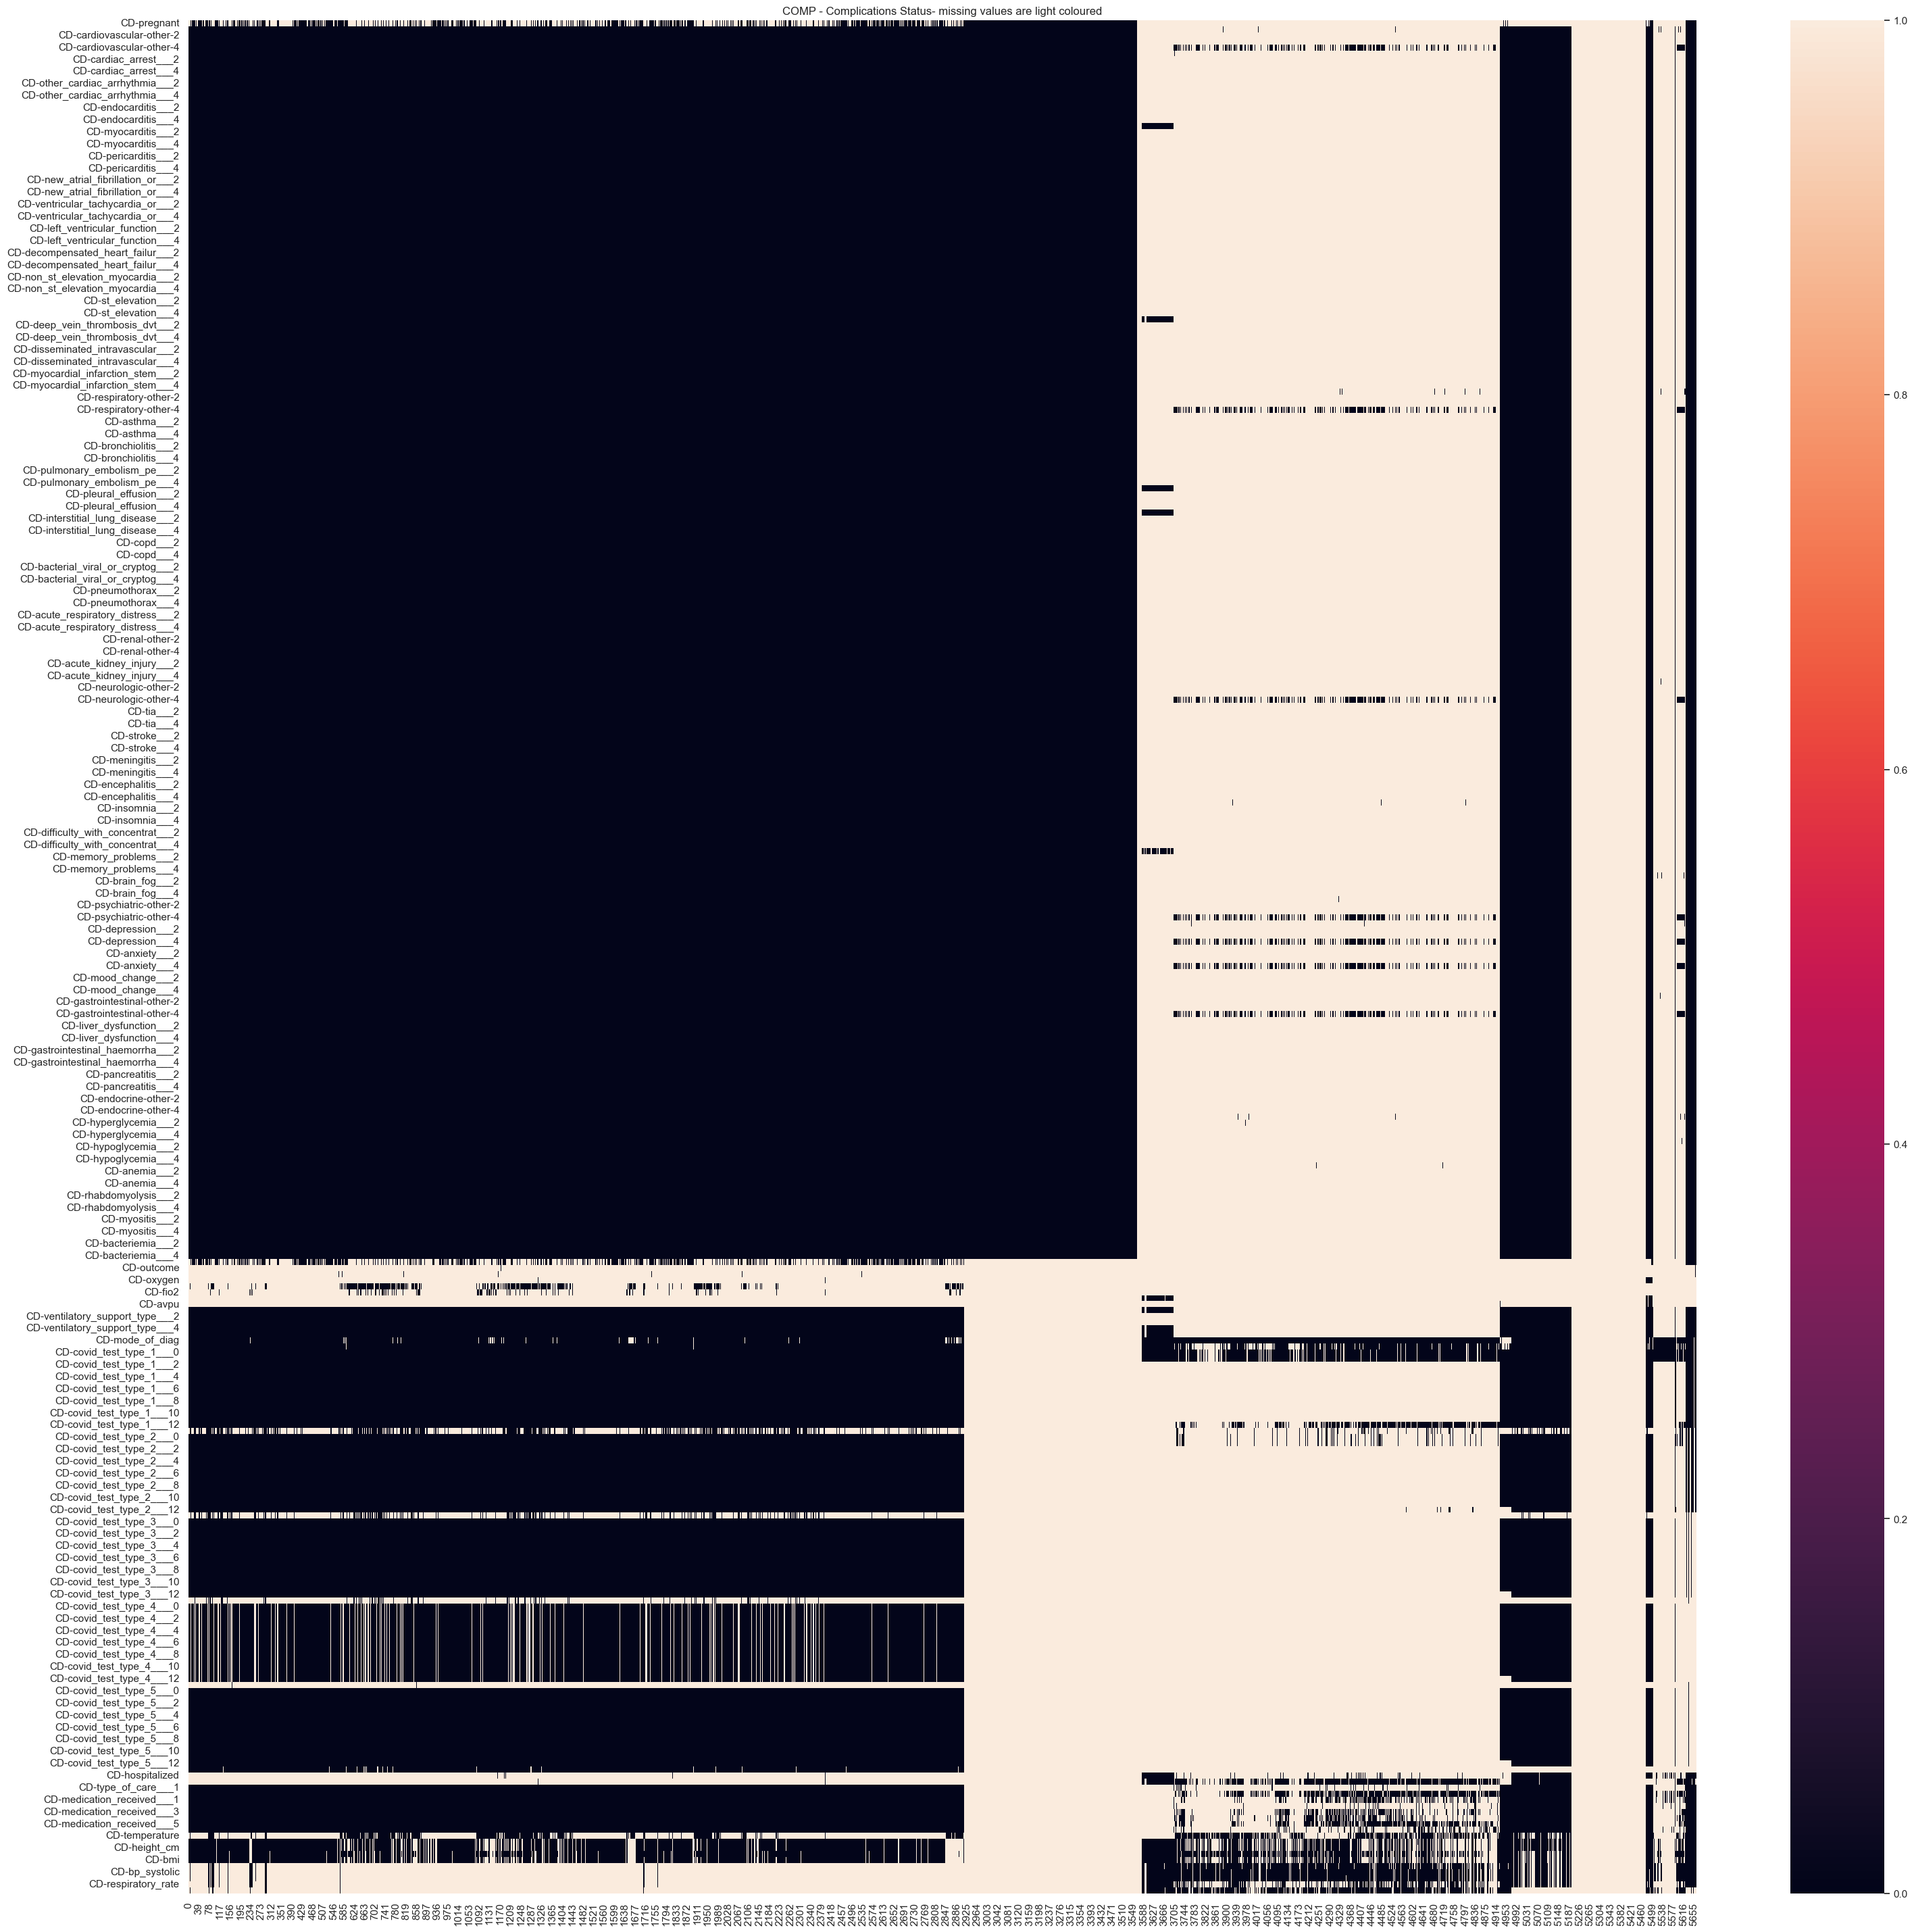

In [94]:

fig, ax = plt.subplots(figsize=(36,36))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("COMP - Complications Status- missing values are light coloured")

In [95]:
# # these features are not very informative - consider dropping them
cd_features = cd_features.drop(columns = cd_features.filter(like = "test_type").columns)

# # height in metres and centimetres is redundant
# # drop the height in cm
cd_features = cd_features.drop(columns = "CD-height_cm")


In [96]:
# sort alphabetically
cd_features = cd_features.reindex(sorted(cd_features.columns), axis=1)

In [97]:
# list of non-binary features - we shouldn't set these to zero!
nb_cd = ["temperature", "height_m", "height_cm", "weight_kgs", "bmi", "heart_rate", "bp_systolic", "bp_diastolic", "respiratory_rate", "o2_saturation", "spo2", "fio2", "gcs"]

nb_cd = [f"CD-{col}" for col in nb_cd]
nb_cd

['CD-temperature',
 'CD-height_m',
 'CD-height_cm',
 'CD-weight_kgs',
 'CD-bmi',
 'CD-heart_rate',
 'CD-bp_systolic',
 'CD-bp_diastolic',
 'CD-respiratory_rate',
 'CD-o2_saturation',
 'CD-spo2',
 'CD-fio2',
 'CD-gcs']

In [98]:
cd_features["CD-severity_level"].value_counts()

CD-severity_level
1.0    2014
2.0     455
3.0     214
0.0     177
Name: count, dtype: int64

In [99]:
#==============================================================================
# 2024-04-28
#==============================================================================
# fill the missing values with zero, per email discussion 2024-04-28

to_fill = [col for col in cd_features.columns if col not in nb_cd]

cd_features[to_fill] = cd_features[to_fill].fillna(0)


In [100]:
cd_features.shape

(5664, 244)

In [101]:
# one hot encode severity level because categories, from 0,1,2,3,4
cd_features['CD-severity_level'] = cd_features['CD-severity_level'].astype(int)

In [102]:
cd_features = pd.get_dummies(cd_features,columns=['CD-severity_level',], prefix='CD-severity_level__')

In [103]:
print("Missing COMP values by site:")
ot1 = cd_features.groupby(df["dag"]).apply(lambda x: x.isnull().sum()).rename(
    index=site_name_dict
).T
ot1

Missing COMP values by site:


dag,LDN,MTL,SAN,RIO,LUS
CD-acute_kidney_injury___1,0,0,0,0,0
CD-acute_kidney_injury___2,0,0,0,0,0
CD-acute_kidney_injury___3,0,0,0,0,0
CD-acute_kidney_injury___4,0,0,0,0,0
CD-acute_respiratory_distress___1,0,0,0,0,0
...,...,...,...,...,...
CD-weight_kgs,267,385,154,668,345
CD-severity_level___0,0,0,0,0,0
CD-severity_level___1,0,0,0,0,0
CD-severity_level___2,0,0,0,0,0


Text(0.5, 1.0, 'CD Status - missing values are light coloured')

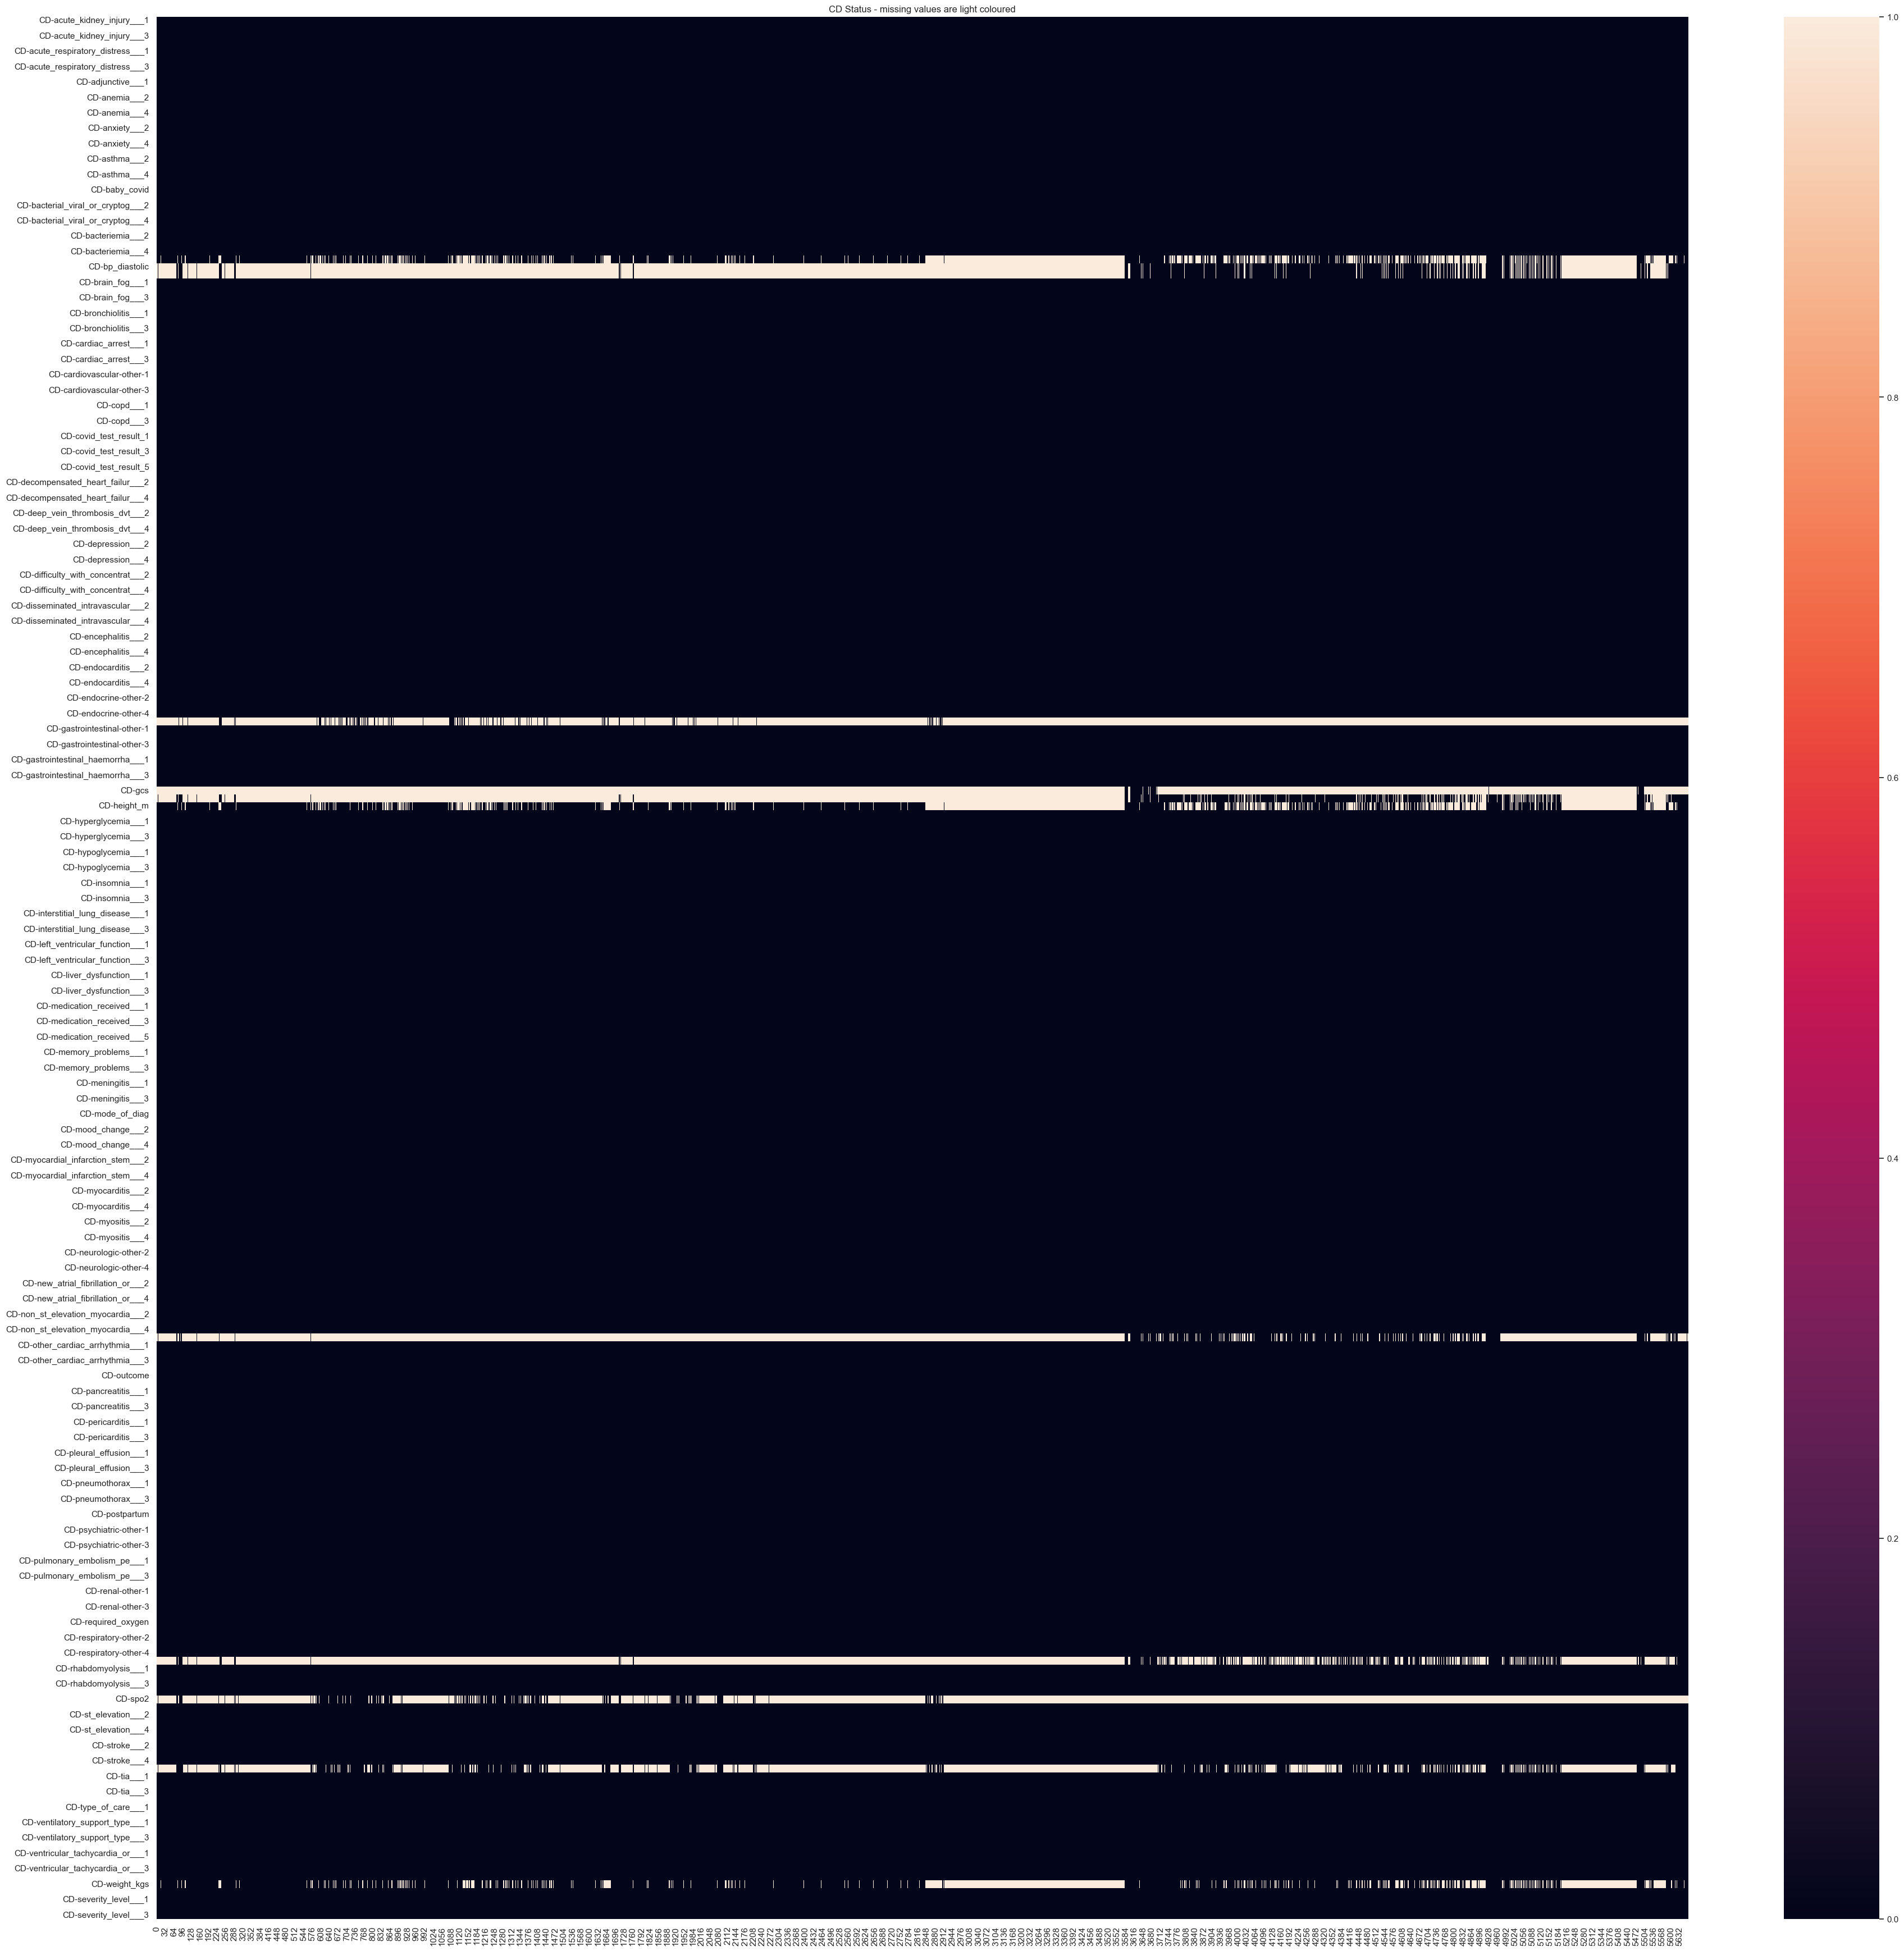

In [104]:

fig, ax = plt.subplots(figsize=(44,44))

sns.heatmap(cd_features.isnull().T, cbar=True, ax = ax, )
plt.title("CD Status - missing values are light coloured")
# missing values by site

##### Convert Vitals and Non-Binary CD to Indicated/NonIndicated

In [105]:
print('confirm data not mistakenly filled wtih 0 for non-binary')
ot1.loc[ot1.sum(axis=1) > 0]

confirm data not mistakenly filled wtih 0 for non-binary


dag,LDN,MTL,SAN,RIO,LUS
CD-bmi,277,480,156,668,642
CD-bp_diastolic,266,2853,149,680,151
CD-bp_systolic,266,2853,149,680,150
CD-fio2,319,2659,340,788,1304
CD-gcs,295,2913,340,681,1303
CD-heart_rate,263,2853,149,681,225
CD-height_m,277,424,116,668,615
CD-o2_saturation,270,2883,336,682,304
CD-respiratory_rate,293,2858,149,681,711
CD-spo2,319,2155,340,788,1304


In [106]:
nb_cd

['CD-temperature',
 'CD-height_m',
 'CD-height_cm',
 'CD-weight_kgs',
 'CD-bmi',
 'CD-heart_rate',
 'CD-bp_systolic',
 'CD-bp_diastolic',
 'CD-respiratory_rate',
 'CD-o2_saturation',
 'CD-spo2',
 'CD-fio2',
 'CD-gcs']

In [107]:
NBCD_IND = [
    "CD-temperature",
    "CD-heart_rate",
    "CD-bp_systolic",
    "CD-bp_diastolic",
    "CD-respiratory_rate",
    "CD-o2_saturation",
    "CD-spo2",
    "CD-fio2",
    "CD-gcs",
]

In [108]:
# ==============================================================================
# 2024-04-28
# ==============================================================================
# Binarize Vital Columns, per email discussion 2024-04-28
# separate vitals and other features

cd_NBCD = cd_features[NBCD_IND]
cd_NBCD = cd_NBCD.fillna(0)

cd_NBCD[cd_NBCD > 0] = 1

cd_features = cd_features[[x for x in cd_features.columns if x not in NBCD_IND+[ 'CD-height_m','CD-height_cm', 'CD-weight_kgs', 'CD-bmi',]]] #remove NB_CD columns and H/W from cd_features
# lab_features_ind.columns = [f"LABS-IND-{col}" for col in lab_features_ind.columns]
cd_NBCD.shape, cd_features.shape

((5664, 9), (5664, 235))

In [109]:
cd_NBCD['CD-spo2'].value_counts()

CD-spo2
0.0    4906
1.0     758
Name: count, dtype: int64

## VACCINES

In [110]:
df['vaccinated'].value_counts(dropna=False)

vaccinated
1.0    4384
NaN    1137
0.0     143
Name: count, dtype: int64

In [111]:
# patient vaccination status
VAX_STATUS = ["vaccinated"]

# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

# unstructured text - save for later analysis
VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

# QUESTION: is the assumption to fill blank values with 0 correct?
# df[VAX] = df[VAX].fillna(0)

# use all features
# vax_features = df[VAX_STATUS + VAX]

#==============================================================================
# use only vaccine status 
# 2024-04-28: confirmed only using VAX status
#==============================================================================
vax_features = df[VAX_STATUS]

print(vax_features.shape)

# prefix VAX- to the column names
vax_features.columns = [f"VAX-{col}" for col in vax_features.columns]


(5664, 1)


In [112]:
#==============================================================================
# 2024-04-28: deprecate this material below
#==============================================================================

# vvv = pd.concat([df[VAX], df['dag']], axis = 1)
# vl = vvv.groupby('dag').sum().T.sum()
# vl
# pd.concat([vax_features, df['dag']], axis = 1).groupby('dag').sum().T.sum()
# # how many rows with dag = 5?
# vvv.query('dag == 5').shape
# # get a subset of vvv for dag = 5
# vl = vvv.query('dag == 5').head()

# # how many nans per column?
# vl.isnull().sum()

# vl
# # count non-zero values per dag
# vvv.groupby(df['dag']).apply(lambda x: x.astype(bool).sum(axis=0)).rename(index = site_name_dict)

# fig, ax = plt.subplots(figsize=(6,6))

# sns.heatmap(vax_features.isnull().T, cbar=True, ax = ax, )
# plt.title("Vaccination Status - missing values are light coloured")

In [113]:
# how many missing values per dag?
print("Missing VAX values by site:")
vax_features.groupby(df['dag']).apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T

Missing VAX values by site:


dag,LDN,MTL,SAN,RIO,LUS
VAX-vaccinated,158,41,7,0,931


In [114]:
#==============================================================================
# 2024-04-28
# In keeping with issues #1, #4, etc., - assume that if it's not reported, it wasn't volunteered by px, nor was it identified by physician/interviewer
# therefore, fill nans with zero
#==============================================================================
vax_features = vax_features.fillna(0)


# SAVE FEATURES TO FILE

In [115]:
# demographic_features
# medication_features
# hx_features_all
# survey_features
# symptom_features
# clinical_features
# vax_features

# concatenate all of the features
features = pd.concat(
    [
        demographic_features,
        medication_features,
        symptom_features,
        vax_features,
        hx_features_all,
        cd_features,  # NOTE: doesnt include vitals
        cd_NBCD,  # NOTE: this is binarized vitals
        imaging_features,
        func_test_features,
        lab_features_ind,
        substance_features,  # selected by MP for now
        # WIP:
        # lab_features, # NOTE: replaced with binarized
        # cd_features, # needs to be revised
        # none
        # NOT SELECTED:
        # survey_features,    # not selected
    ],
    axis=1,
)

features["LC_STATUS"] = df["LC_STATUS"]

In [116]:
features.shape

(5664, 448)

In [117]:
# count the nulls per site
print("Missing values by site:")

features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()

Missing values by site:


/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_80466/4098030052.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features.groupby('dag').apply(lambda x: x.isnull().sum()).rename(index = site_name_dict).T.sum()


dag
LDN     1
MTL     0
SAN     0
RIO     2
LUS    91
dtype: int64

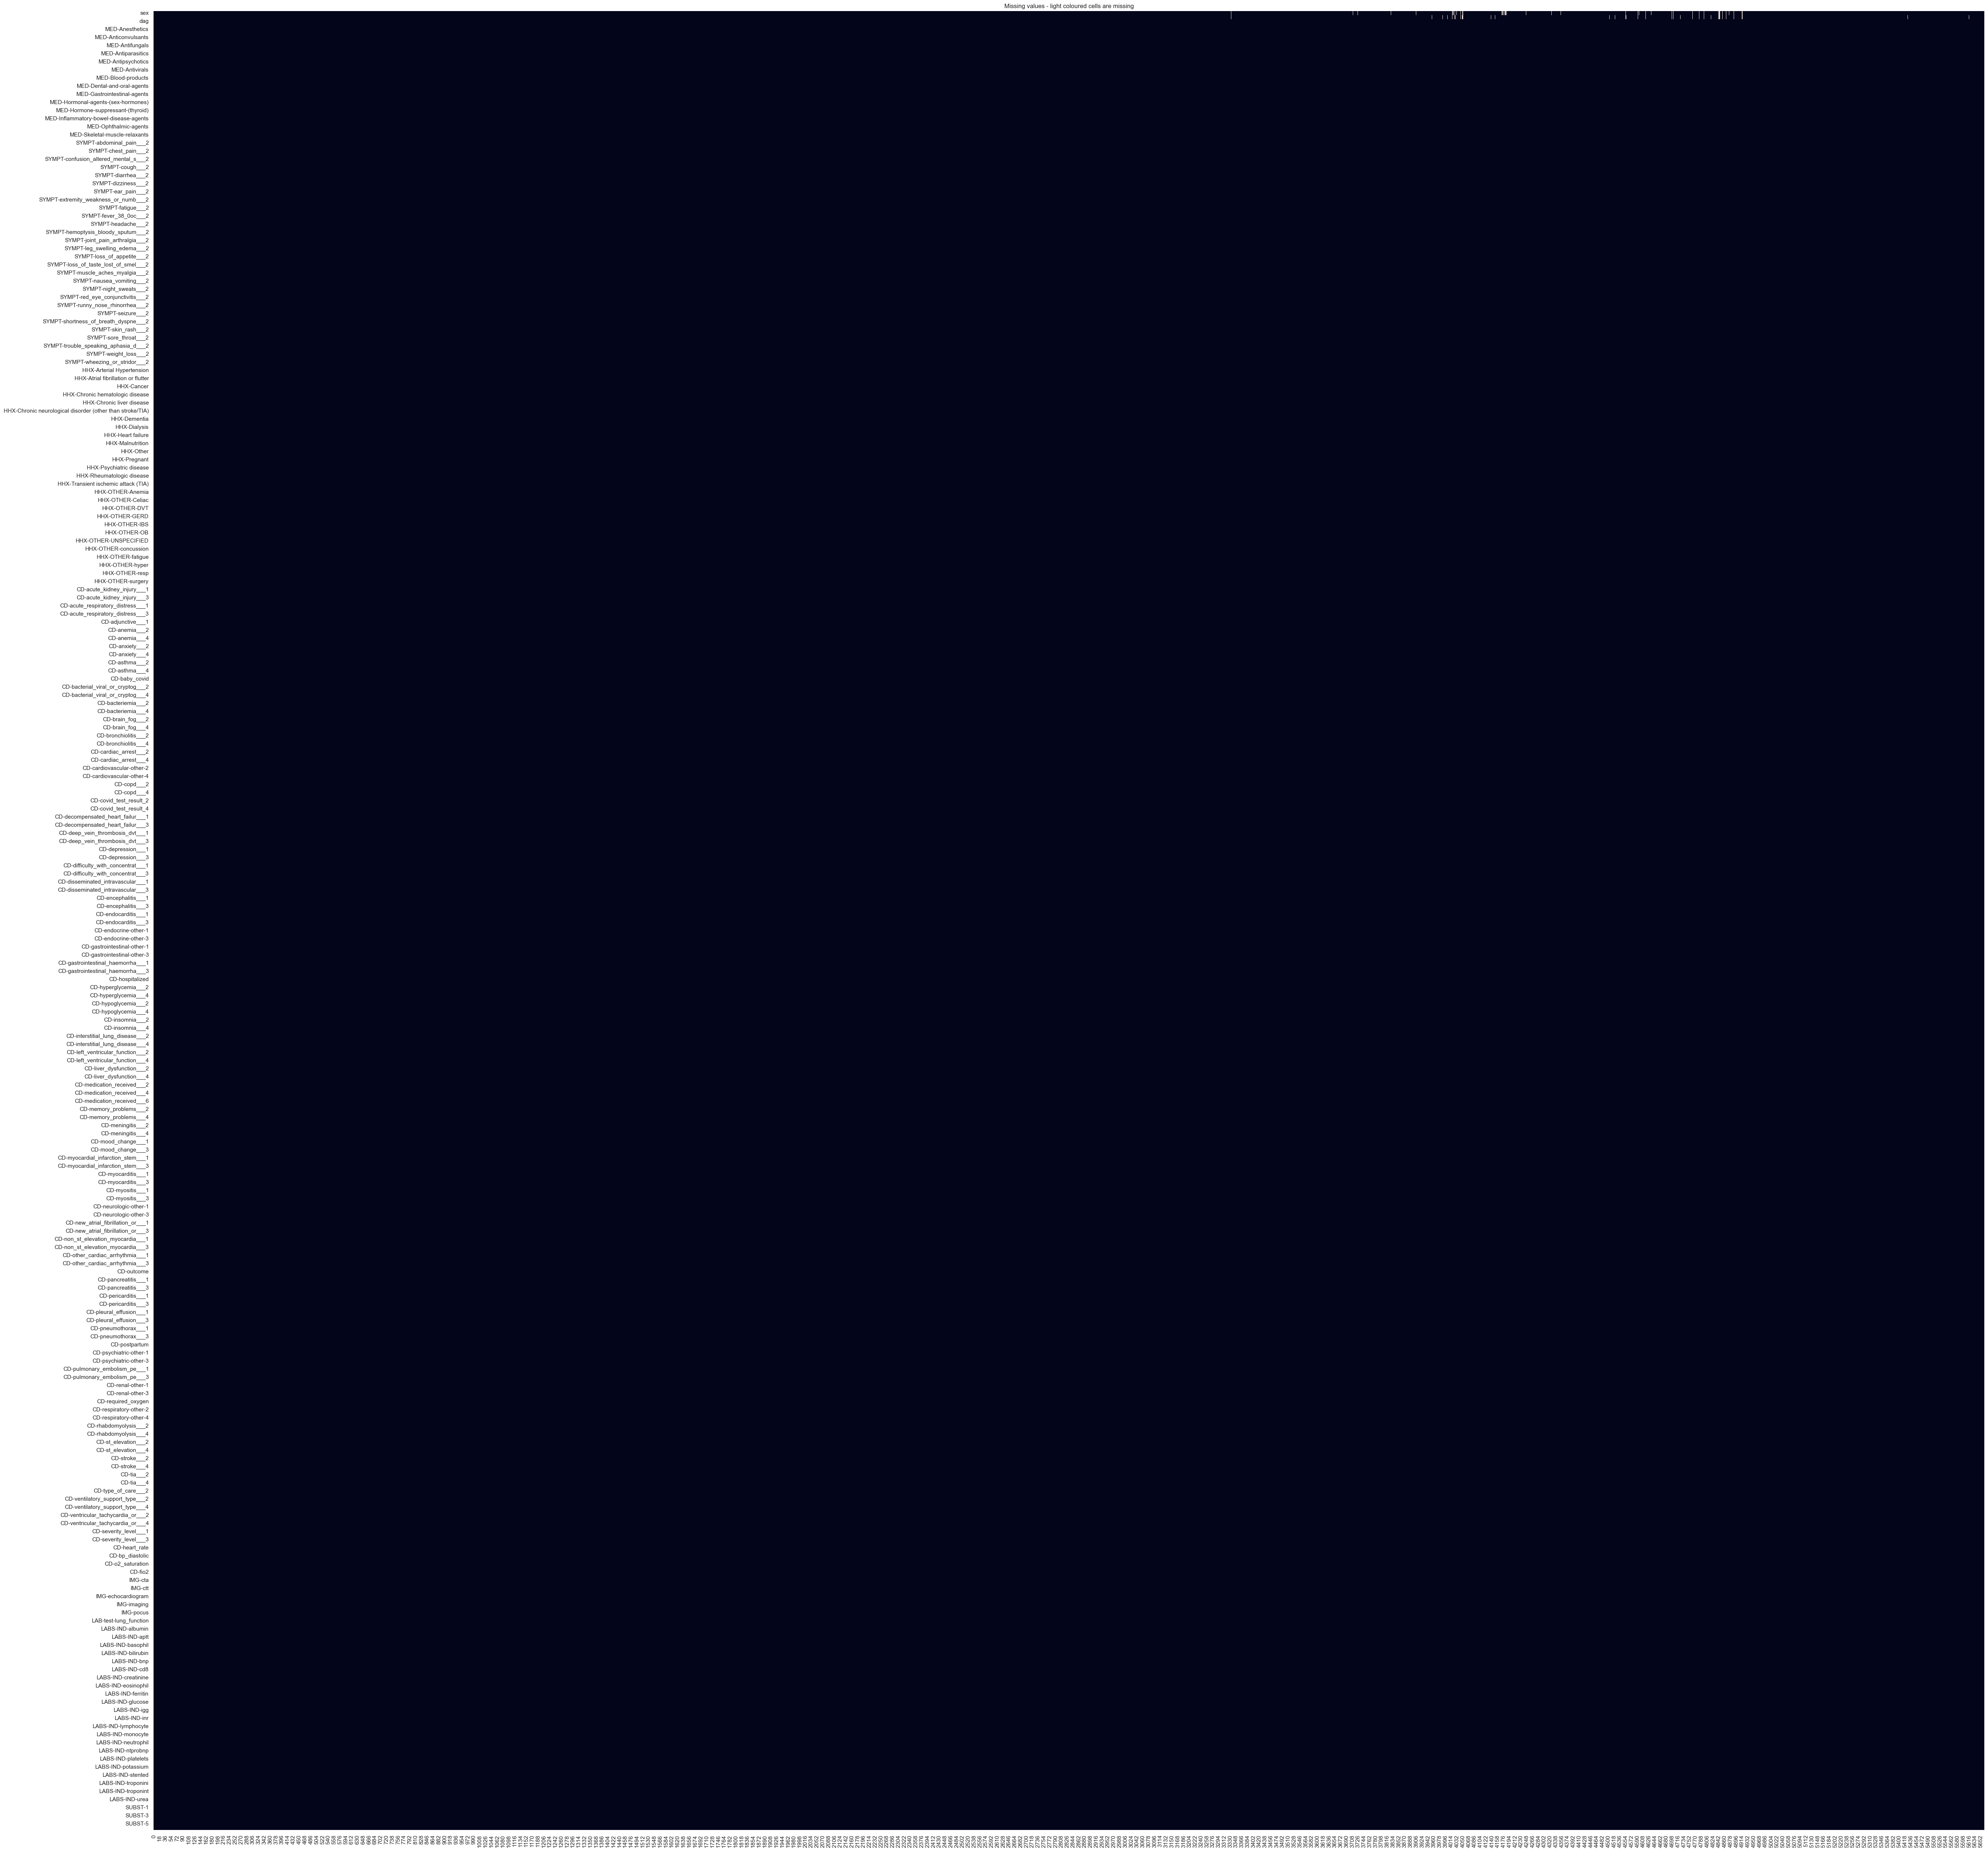

In [118]:
fig, ax = plt.subplots(figsize=(64,64))

sns.heatmap(features.isnull().T, cbar=False, ax = ax)

plt.title("Missing values - light coloured cells are missing")
# set small font
plt.rcParams.update({'font.size': 8})

In [119]:
# quality activities

features.columns = features.columns.str.strip()  # ensure columns are clean
features = features.rename(columns={'dag':'SITE'}) #rename dag to 

In [120]:
# using the arrow dataset format is way faster than excel
# ~0.0s vs > 15s for the excel file

import datasets

# get today's data as a string
import datetime
today = datetime.date.today().strftime("%Y-%m-%d")


# make a dataset
ds = datasets.arrow_dataset.Dataset.from_pandas(features, preserve_index=True)
ds.save_to_disk(output_path / f"{today}-features.arrow")

Saving the dataset (0/1 shards):   0%|          | 0/5664 [00:00<?, ? examples/s]

In [121]:
features.columns

Index(['sex', 'age', 'SITE', 'MED-Analgesics', 'MED-Anesthetics',
       'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants',
       'MED-Antifungals', 'MED-Antimigraine-agents',
       ...
       'LABS-IND-troponint', 'LABS-IND-troponinthigh', 'LABS-IND-urea',
       'LABS-IND-wbc', 'SUBST-1', 'SUBST-2', 'SUBST-3', 'SUBST-4', 'SUBST-5',
       'LC_STATUS'],
      dtype='object', length=448)